# Background

- Now that I have time information, this notebook will use the more refined processed data.

# Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from copy import deepcopy
import numpy as np
import pandas as pd
import lmfit as lm
from scipy import optimize
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

# local imports
from plotting import config_plots, get_label
config_plots()

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

from load_slow import load_data
from load_survey import *
from survey_axis_analysis import *

In [3]:
raw_ddir = '/home/ckampa/Dropbox/LogFiles/survey_12-06-22/'
survey_ddir = '/home/ckampa/Dropbox/LogFiles/Dec22_Survey_Data/'
proc_ddir = 'data/'
plot_dir = 'plots/'

# Load / Inital Processing

- Load data for groups and measurements
- Process (interpolation of slow controls, etc.)
- Fit a plane to each group.
    - For now only including situations where all 5 targets are in the group.

In [4]:
# load data
data_file = raw_ddir+'2022-12-06 093302slow.txt'
group_time_file = raw_ddir+'group_time_table_12-06-22_to_12-08-22.txt'

In [5]:
cols = ['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]', 'NMR [FFT]',
        'SmarAct_Meas_Angle_1', 'SmarAct_Meas_Rotation_Angle_1', 'SmarAct_Meas_Angle_2', 'SmarAct_Meas_Rotation_Angle_2']

In [6]:
df_slow = load_data(data_file, header=cols).iloc[1:]

In [7]:
df_groups = load_group_df(group_time_file, df_slow)

In [8]:
df_meas, df_groups = construct_meas_df(df_groups, survey_ddir)

In [9]:
df_groups

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,all_targets
Datetime,,,,,,,,,,,
2022-12-06 14:10:24,Black Plate Repeatability - 10th Installation ...,12-06-22 14:10:24,16639.0,True,357.999999,346.999992,6.248279,6.056292,0,True,True
2022-12-06 14:20:24,Black Plate Repeatability - 11th Installation,12-06-22 14:20:24,17239.0,True,357.999799,346.999992,6.248275,6.056292,1,True,True
2022-12-06 14:30:24,Black Plate Repeatability - 12th Installation,12-06-22 14:30:24,17839.0,True,357.999995,346.999993,6.248279,6.056292,2,True,True
2022-12-06 14:40:24,Black Plate Repeatability - 13th Installation,12-06-22 14:40:24,18439.0,True,357.999995,347.000003,6.248279,6.056293,3,True,True
2022-12-06 14:50:24,Black Plate Repeatability - 14th Installation,12-06-22 14:50:24,19039.0,True,357.999986,346.999998,6.248278,6.056292,4,True,True
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 10:02:10,Black Plate Vertical Rotation 90 Degrees C,12-08-22 10:02:10,174545.0,False,357.999997,89.999996,6.248279,1.570796,84,True,True
2022-12-08 10:05:30,Horizontal -5 Degrees Vertical 90 Degrees C,12-08-22 10:05:30,174745.0,False,354.999993,89.999989,6.195919,1.570796,85,True,True
2022-12-08 10:09:49,Black Plate Vertical Rotation 135 Degrees C,12-08-22 10:09:49,175004.0,False,357.999995,134.999997,6.248279,2.356194,86,True,True


In [10]:
df_groups.query("not can_analyze")

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,all_targets
Datetime,,,,,,,,,,,
2022-12-07 15:01:35,Black Plate Vertical Rotation 30 Degrees Check,12-07-22 15:01:35,106110.0,False,358.000004,29.999997,6.248279,0.523599,60,False,False
2022-12-07 15:04:27,Black Plate Horizontal Rotation 0 Degrees Check,12-07-22 15:04:27,106282.0,False,359.999998,347.000000,6.283185,6.056293,61,False,False
2022-12-07 15:07:20,Black Plate Vertical Rotation 315 Degrees Check,12-07-22 15:07:20,106455.0,False,357.999992,314.999996,6.248279,5.497787,62,False,False
2022-12-07 15:08:41,Black Plate Vertical Rotation 180 Degrees Check,12-07-22 15:08:41,106536.0,False,357.999997,179.999993,6.248279,3.141593,63,False,False
2022-12-07 15:10:36,Black Plate Vertical Rotation 90 Degrees Check,12-07-22 15:10:36,106651.0,False,358.000002,90.000001,6.248279,1.570796,64,False,False


In [11]:
df_groups.query("(can_analyze) and (not all_targets)")

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,all_targets
Datetime,,,,,,,,,,,
2022-12-08 08:49:16,Black Plate Vertical Rotation 135 Degrees Check,12-08-22 08:49:16,170171.0,False,357.999995,134.999996,6.248279,2.356194,67,True,False
2022-12-08 08:56:16,Black Plate Repeatability - 26th Installation ...,12-08-22 08:56:16,170591.0,True,358.000000,134.999995,6.248279,2.356194,68,True,False


In [12]:
# ONLY LOOK AT GROUPS WE CAN ANALYZE. MAKE SURE I REMEMBER THIS
#df_groups = df_groups.query('can_analyze').copy()
# OR
# ONLY LOOK AT GROUPS WITH ALL TARGETS. MAKE SURE I REMEMBER THIS
df_groups = df_groups.query('all_targets').copy()
# remove any measurements that aren't in the groups being analyzed
df_meas = df_meas[np.isin(df_meas.Group_Index, df_groups.Group_Index)].copy()

In [13]:
# run analysis steps
df_groups = analyze_all_groups_plane(df_groups, df_meas)

Groups: 82
column: norm_v, len of results: 82
column: norm_v_x, len of results: 82
column: norm_v_y, len of results: 82
column: norm_v_z, len of results: 82
column: centroid, len of results: 82
column: centroid_x, len of results: 82
column: centroid_y, len of results: 82
column: centroid_z, len of results: 82
column: vec_y, len of results: 82
column: vec_y_x, len of results: 82
column: vec_y_y, len of results: 82
column: vec_y_z, len of results: 82
column: vec_x, len of results: 82
column: vec_x_x, len of results: 82
column: vec_x_y, len of results: 82
column: vec_x_z, len of results: 82


In [14]:
df_groups

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-06 14:10:24,Black Plate Repeatability - 10th Installation ...,12-06-22 14:10:24,16639.0,True,357.999999,346.999992,6.248279,6.056292,0,True,...,-0.015366,0.135423,-0.990669,"[0.00843592122764007, -0.9907329102590897, -0....",0.008436,-0.990733,-0.135562,0.000000,0.000000,0.000000
2022-12-06 14:20:24,Black Plate Repeatability - 11th Installation,12-06-22 14:20:24,17239.0,True,357.999799,346.999992,6.248275,6.056292,1,True,...,-0.015961,0.135716,-0.990619,"[0.008329827347464023, -0.9906930330086997, -0...",0.008330,-0.990693,-0.135860,0.000591,0.033882,0.003789
2022-12-06 14:30:24,Black Plate Repeatability - 12th Installation,12-06-22 14:30:24,17839.0,True,357.999995,346.999993,6.248279,6.056292,2,True,...,-0.013790,0.133320,-0.990977,"[0.005762044179601676, -0.9910442815196192, -0...",0.005762,-0.991044,-0.133409,0.003124,0.179018,0.014879
2022-12-06 14:40:24,Black Plate Repeatability - 13th Installation,12-06-22 14:40:24,18439.0,True,357.999995,347.000003,6.248279,6.056293,3,True,...,-0.015347,0.135749,-0.990624,"[0.006728479486120245, -0.9907046657808206, -0...",0.006728,-0.990705,-0.135864,0.001703,0.097565,0.002602
2022-12-06 14:50:24,Black Plate Repeatability - 14th Installation,12-06-22 14:50:24,19039.0,True,357.999986,346.999998,6.248278,6.056292,4,True,...,-0.015807,0.135701,-0.990624,"[0.006684830747934325, -0.9907109763094498, -0...",0.006685,-0.990711,-0.135820,0.001800,0.103154,0.003978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 10:02:10,Black Plate Vertical Rotation 90 Degrees C,12-08-22 10:02:10,174545.0,False,357.999997,89.999996,6.248279,1.570796,84,True,...,-0.007025,0.942286,0.334734,"[-0.01708701413013696, 0.3345803663793403, -0....",-0.017087,0.334580,-0.942212,0.001850,0.106005,0.553892
2022-12-08 10:05:30,Horizontal -5 Degrees Vertical 90 Degrees C,12-08-22 10:05:30,174745.0,False,354.999993,89.999989,6.195919,1.570796,85,True,...,0.042344,0.942399,0.331799,"[0.00021110485630057227, 0.3320886660800678, -...",0.000211,0.332089,-0.943248,0.050539,2.895651,0.551095
2022-12-08 10:09:49,Black Plate Vertical Rotation 135 Degrees C,12-08-22 10:09:49,175004.0,False,357.999995,134.999997,6.248279,2.356194,86,True,...,0.006647,0.432045,0.901828,"[-0.016970739865649304, 0.9017662914716766, -0...",-0.016971,0.901766,-0.431891,0.002065,0.118329,0.684584


In [15]:
df_groups.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2022-12-06 14:10:24 to 2022-12-08 10:18:55
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Group              82 non-null     object 
 1   Time               82 non-null     object 
 2   seconds_delta      82 non-null     float64
 3   Stage_Removed      82 non-null     bool   
 4   SmarAct1_Meas_Deg  82 non-null     float64
 5   SmarAct2_Meas_Deg  82 non-null     float64
 6   SmarAct1_Meas_Rad  82 non-null     float64
 7   SmarAct2_Meas_Rad  82 non-null     float64
 8   Group_Index        82 non-null     int64  
 9   can_analyze        82 non-null     bool   
 10  all_targets        82 non-null     bool   
 11  norm_v             82 non-null     object 
 12  norm_v_x           82 non-null     float64
 13  norm_v_y           82 non-null     float64
 14  norm_v_z           82 non-null     float64
 15  centroid           82 non-null     obj

# Some Initial Plotting

In [32]:
# plot movement of normal vector
df_ = df_groups.iloc[[i for i, g in enumerate(df_groups.Group) if 'Repeat' in g]]
df_rep = df_groups.query("Stage_Removed")

fig, ax = plt.subplots()

ax.scatter(df_.Group_Index, df_.dnorm_v_Deg, label='All Reproducibility')
ax.scatter(df_rep.Group_Index, df_rep.dnorm_v_Deg, c='red', marker='+', label='Stage Removed')

ax.legend()
ax.set_xlabel('Measurement (Group) Index')
ax.set_ylabel(r'$\Delta \hat{n}$ [Degrees]');

<IPython.core.display.Javascript object>

In [30]:
df_groups.columns

Index(['Group', 'Time', 'seconds_delta', 'Stage_Removed', 'SmarAct1_Meas_Deg',
       'SmarAct2_Meas_Deg', 'SmarAct1_Meas_Rad', 'SmarAct2_Meas_Rad',
       'Group_Index', 'can_analyze', 'all_targets', 'norm_v', 'norm_v_x',
       'norm_v_y', 'norm_v_z', 'centroid', 'centroid_x', 'centroid_y',
       'centroid_z', 'vec_y', 'vec_y_x', 'vec_y_y', 'vec_y_z', 'vec_x',
       'vec_x_x', 'vec_x_y', 'vec_x_z', 'dnorm_v_Rad', 'dnorm_v_Deg',
       'dcentroid'],
      dtype='object')

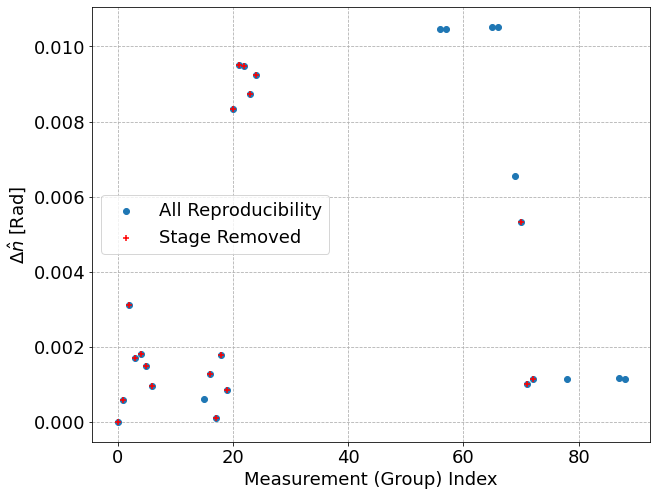

In [31]:
# plot movement of normal vector
df_ = df_groups.iloc[[i for i, g in enumerate(df_groups.Group) if 'Repeat' in g]]
df_rep = df_groups.query("Stage_Removed")

fig, ax = plt.subplots()

ax.scatter(df_.Group_Index, df_.dnorm_v_Rad, label='All Reproducibility')

#ax.scatter(df_rep.Group_Index, 0.006 *np.ones(len(df_rep)), c='red', marker='+')
ax.scatter(df_rep.Group_Index, df_rep.dnorm_v_Rad, c='red', marker='+', label='Stage Removed')

ax.legend()
ax.set_xlabel('Measurement (Group) Index')
ax.set_ylabel(r'$\Delta \hat{n}$ [Rad]');

In [32]:
df_.query('Group_Index < 20')[['dcentroid', 'dnorm_v_Rad']].describe()

,dcentroid,dnorm_v_Rad
count,12.000000,12.000000
mean,0.005496,0.001193
std,0.004841,0.000867
min,0.000000,0.000000
25%,0.002630,0.000612
50%,0.003883,0.001125
75%,0.005816,0.001721
max,0.014879,0.003124


In [33]:
df_.query('Group_Index < 20')[['dcentroid', 'dnorm_v_Rad']]

,dcentroid,dnorm_v_Rad
Datetime,,
2022-12-06 14:10:24,0.000000,0.000000
2022-12-06 14:20:24,0.003789,0.000591
2022-12-06 14:30:24,0.014879,0.003124
2022-12-06 14:40:24,0.002602,0.001703
2022-12-06 14:50:24,0.003978,0.001800
2022-12-06 15:00:24,0.004294,0.001499
2022-12-06 15:10:24,0.003638,0.000967
2022-12-06 15:46:55,0.004320,0.000620
2022-12-07 08:11:31,0.010305,0.001284


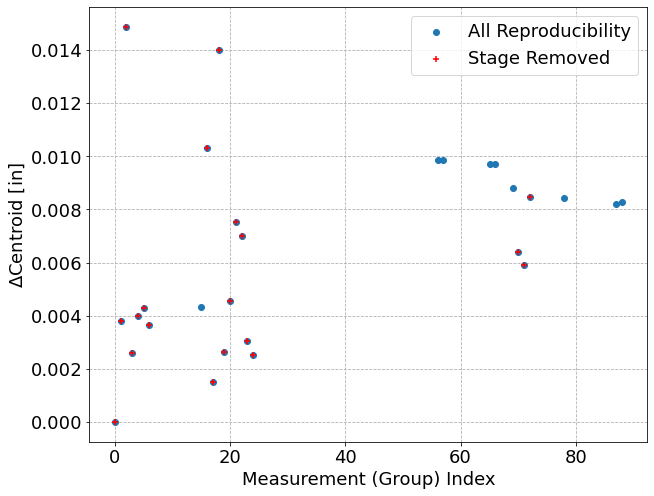

In [34]:
# plot movement of centroid
df_ = df_groups.iloc[[i for i, g in enumerate(df_groups.Group) if 'Repeat' in g]]
df_rep = df_groups.query("Stage_Removed")

fig, ax = plt.subplots()

ax.scatter(df_.Group_Index, df_.dcentroid, label='All Reproducibility')

#ax.scatter(df_rep.Group_Index, 0.006 *np.ones(len(df_rep)), c='red', marker='+')
ax.scatter(df_rep.Group_Index, df_rep.dcentroid, c='red', marker='+', label='Stage Removed')

ax.legend()
ax.set_xlabel('Measurement (Group) Index')
ax.set_ylabel(r'$\Delta$Centroid [in]');

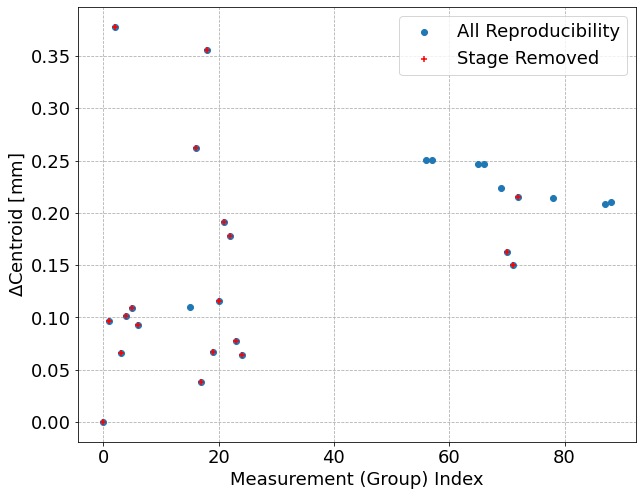

In [35]:
# plot movement of centroid
df_ = df_groups.iloc[[i for i, g in enumerate(df_groups.Group) if 'Repeat' in g]]
df_rep = df_groups.query("Stage_Removed")

fig, ax = plt.subplots()

ax.scatter(df_.Group_Index, inch_to_mm(df_.dcentroid), label='All Reproducibility')

#ax.scatter(df_rep.Group_Index, 0.006 *np.ones(len(df_rep)), c='red', marker='+')
ax.scatter(df_rep.Group_Index, inch_to_mm(df_rep.dcentroid), c='red', marker='+', label='Stage Removed')

ax.legend()
ax.set_xlabel('Measurement (Group) Index')
ax.set_ylabel(r'$\Delta$Centroid [mm]');

In [36]:
df_groups.query('norm_v_x < 0')

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,


In [37]:
df_meas

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,Group,Group_Index,Datetime
0,A,0.122124,1.193630,-1.959151,3.101950,30.318202,-49.762435,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
1,B,0.139268,-0.565170,-2.160190,3.537407,-14.355318,-54.868826,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
2,C,0.170145,-1.336052,-0.441168,4.321683,-33.935721,-11.205667,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
3,D,0.194417,-0.306260,2.005804,4.938192,-7.779004,50.947422,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
4,E,0.151015,1.202173,0.004039,3.835781,30.535194,0.102591,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
...,...,...,...,...,...,...,...,...,...,...
0,A,0.118483,1.150370,-1.985691,3.009468,29.219398,-50.436551,Black Plate Repeatability - 29th Installation ...,88,2022-12-08 10:18:55
1,B,0.138190,-0.612875,-2.144690,3.510026,-15.567025,-54.475126,Black Plate Repeatability - 29th Installation ...,88,2022-12-08 10:18:55
2,C,0.168725,-1.342556,-0.407690,4.285615,-34.100922,-10.355326,Black Plate Repeatability - 29th Installation ...,88,2022-12-08 10:18:55
3,D,0.190342,-0.250500,2.013964,4.834687,-6.362700,51.154686,Black Plate Repeatability - 29th Installation ...,88,2022-12-08 10:18:55


In [38]:
len(df_meas) / len(df_groups)

5.0

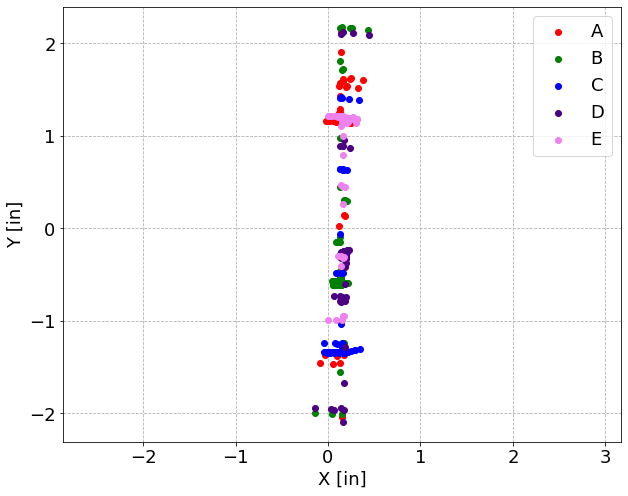

In [39]:
# plot everything, out of curiousity.
fig, ax = plt.subplots()

names = ['A', 'B', 'C', 'D', 'E']
colors = ['red', 'green', 'blue', 'indigo', 'violet']

for n, c in zip(names, colors):
    df_ = df_meas.query(f'Point == "{n}"')
    ax.scatter(df_.X, df_.Y, c=c, label=n)

ax.axis('equal')
    
ax.set_xlabel('X [in]')
ax.set_ylabel('Y [in]')
ax.legend();

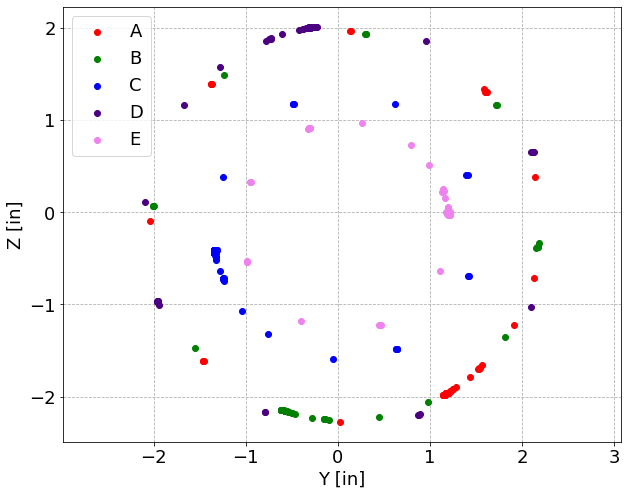

In [40]:
# X, Y plane should show this motion
fig, ax = plt.subplots()

names = ['A', 'B', 'C', 'D', 'E']
colors = ['red', 'green', 'blue', 'indigo', 'violet']

for n, c in zip(names, colors):
    df_ = df_meas.query(f'Point == "{n}"')
    ax.scatter(df_.Y, df_.Z, c=c, label=n)

ax.axis('equal')
    
ax.set_xlabel('Y [in]')
ax.set_ylabel('Z [in]')
ax.legend();

In [41]:
# floor, approximate dimensions
# this is based on laser measurements I did 06-07-21. These are assuming center of magnet gap is center of magnet base
# CAUTION! This also assumes the LT coordinates set up based on the magnet have XY plane completely coplanar with the floor.
ypos_floor = mm_to_inch((0 + 0.838/2 + 1.307)*1e3) # m --> mm --> inch
yneg_floor = mm_to_inch((0 - 0.838/2 - 0.594)*1e3) # m --> mm --> inch
xpos_floor = mm_to_inch((0 + 0.825/2 + 0.270)*1e3) # m --> mm --> inch
xneg_floor = mm_to_inch((0 - 0.825/2 - 0.730)*1e3) # m --> mm --> inch
z_floor_height = -20. # ~17 inch to middle of magnet, plus extra few inches elevated from floor. NOT ACTUALLY SURE....THIS IS A GUESS.
xs_fl = [xneg_floor, xpos_floor]
ys_fl = [yneg_floor, ypos_floor]
X_FL, Y_FL = np.meshgrid(xs_fl, ys_fl)
Z_FL = z_floor_height*np.ones_like(X_FL)
# door
x0_door = xneg_floor
y0_door = (ypos_floor+yneg_floor)/2
Ly_door = 36.
Lz_door = 78.
ys_do = [y0_door-Ly_door/2, y0_door+Ly_door/2]
zs_do = [z_floor_height, z_floor_height+Lz_door]
Y_DO, Z_DO = np.meshgrid(ys_do, zs_do)
X_DO = x0_door*np.ones_like(Y_DO)
# laser tracker, approximate
# Lx_LT = 2.
# Ly_LT = 4.
# Lz_LT = 4.
X0_LT = 1.
Y0_LT = -22.
Z0_LT = 5.
# X_LT = []
# Y_LT = []
# Z_LT = []
# for s_x, s_y in zip([-1, -1, 1, 1], [-1, 1, -1, 1]):
#     X_LT.append([])

In [59]:
(ypos_floor-yneg_floor)

107.83464566929135

In [60]:
mm_to_inch(2.739*1e3)

107.83464566929135

In [62]:
(xpos_floor-xneg_floor)

71.85039370078741

In [63]:
mm_to_inch(1.825*1e3)

71.85039370078741

In [64]:
(ypos_floor+yneg_floor)/2

14.035433070866148

In [61]:
yneg_floor

-39.881889763779526

In [54]:
7*12 +10

94

In [53]:
7*12 +1

85

In [55]:
2.739-1.307-0.594

0.838

In [56]:
1.825 - 0.270 - 0.730

0.825

In [77]:
mm_to_inch(831/2)

16.358267716535433

In [80]:
# plot a single group
group_ind = 0
current_dir = 1
# current_dir = -1

point_dict = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
}
point_cmap = [
    [0/4, 'red'],
    [1/4, 'green'],
    [2/4, 'blue'],
    [3/4, 'indigo'],
    [4/4, 'violet'],
]

df_m = df_meas.query(f'Group_Index == {group_ind}')
df_g = df_groups.query(f'Group_Index == {group_ind}')

thetas = np.linspace(0, 2*np.pi, 100)
# thetas = np.arange(0, 2*np.pi, 2*np.pi/100)
R = mm_to_inch(250./2)
Rs = np.linspace(0, R, 3)
TH, RR = np.meshgrid(thetas, Rs)
pole_pos = [mm_to_inch(75./2)*np.ones_like(TH), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "South" for positive current --> blue. field points north to south
pole_neg = [mm_to_inch(-75./2*np.ones_like(TH)), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "Norht" for positive current --> red. field points north to south
# pole_pos = [mm_to_inch(75./2)*np.ones_like(thetas), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "South" for positive current --> blue. field points north to south
# pole_neg = [mm_to_inch(-75./2*np.ones_like(thetas)), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "Norht" for positive current --> red. field points north to south
if current_dir > 0:
    pole_labels = ['South', 'North']
    pole_colors = ['blue', 'red']
else:
    pole_labels = ['North', 'South']
    pole_colors = ['red', 'blue']
#cvals = np.ones_like(thetas)
cvals = np.ones_like(TH)

data = [
    # Pole Faces
    go.Surface(x=pole_[0], y=pole_[1], z=pole_[2], surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,c_]],
               showscale=False,
               showlegend=True,
               #legendgroup=1,
               opacity=0.8,
               name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
              )
for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

# floor
data.append(
    go.Surface(x=X_FL, y=Y_FL, z=Z_FL, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(130,130,130,0.9)']],
               showscale=False,
               showlegend=True,
               #legendgroup=1,
               #opacity=0.8,
               name=f'Floor (approx., assumes LT coords. XY coplanar to floor)',
              )
)
# door
data.append(
    go.Surface(x=X_DO, y=Y_DO, z=Z_DO, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(250,247,155,0.9)']],
               showscale=False,
               showlegend=True,
               #legendgroup=1,
               #opacity=0.8,
               name=f'Door',
              )
)

# Laser Tracker approx. location
data.append(go.Scatter3d(x=[X0_LT], y=[Y0_LT], z=[Z0_LT], mode='markers',
                         name='Laser Tracker (approx.)',
                         marker=dict(size=2, color='red', symbol='x',),
#                          hovertemplate=f'{df_m.Point}',
                        )
           )

# data = [
#     # Pole Faces
#     go.Scatter3d(x=pole_[0], y=pole_[1], z=pole_[2], mode='lines+markers',
#                name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
#               )
# for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

# data = [
#     # Pole Faces
#     go.Mesh3d(x=pole_[0], y=pole_[1], z=pole_[2], color=c_, opacity=0.8,
#                name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
#               )
# for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

data.append(go.Scatter3d(x=df_m.X, y=df_m.Y, z=df_m.Z, mode='markers',
                         name='LT Measurements',
                         text=df_m.Point,
                         marker=dict(size=4, color=[point_dict[i] for i in df_m.Point], colorscale=point_cmap),
#                          hovertemplate=f'{df_m.Point}',
                        )
           )

layout = go.Layout(
    title='Survey of SmarAct Kinematic Mounting Plate',
    scene=dict(
        xaxis=dict(title='X [inch]'),
        yaxis=dict(title='Y [inch]'),
        zaxis=dict(title='Z [inch]'),
        aspectmode='data',
    ),
    #plot_bgcolor='rgb(240, 240, 240)',
)

fig = go.Figure(data=data, layout=layout)
fig.write_html(plot_dir+'plotly_3d_test.html')

In [29]:
fig.show()

In [133]:
# slider to select group
current_dir = 1
# current_dir = -1

point_dict = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
}
point_cmap = [
    [0/4, 'red'],
    [1/4, 'green'],
    [2/4, 'blue'],
    [3/4, 'indigo'],
    [4/4, 'violet'],
]

thetas = np.linspace(0, 2*np.pi, 100)
# thetas = np.arange(0, 2*np.pi, 2*np.pi/100)
R = mm_to_inch(250./2)
Rs = np.linspace(0, R, 3)
TH, RR = np.meshgrid(thetas, Rs)
pole_pos = [mm_to_inch(75./2)*np.ones_like(TH), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "South" for positive current --> blue. field points north to south
pole_neg = [mm_to_inch(-75./2*np.ones_like(TH)), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "Norht" for positive current --> red. field points north to south
# pole_pos = [mm_to_inch(75./2)*np.ones_like(thetas), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "South" for positive current --> blue. field points north to south
# pole_neg = [mm_to_inch(-75./2*np.ones_like(thetas)), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "Norht" for positive current --> red. field points north to south
if current_dir > 0:
    pole_labels = ['South', 'North']
    pole_colors = ['blue', 'red']
else:
    pole_labels = ['North', 'South']
    pole_colors = ['red', 'blue']
#cvals = np.ones_like(thetas)
cvals = np.ones_like(TH)

data = [
    # Pole Faces
    go.Surface(x=pole_[0], y=pole_[1], z=pole_[2], surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,c_]],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
              )
for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

# floor
data.append(
    go.Surface(x=X_FL, y=Y_FL, z=Z_FL, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(130,130,130,0.9)']],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Floor (approx., assumes LT coords. XY coplanar to floor)',
              )
)
# door
data.append(
    go.Surface(x=X_DO, y=Y_DO, z=Z_DO, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(250,247,155,0.9)']],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Door',
              )
)

# Laser Tracker approx. location
data.append(go.Scatter3d(x=[X0_LT], y=[Y0_LT], z=[Z0_LT], mode='markers',
                         name='Laser Tracker (approx.)',
                         marker=dict(size=2, color='red', symbol='x',),
                         opacity=1.0,
                        )
           )

groups_ind = df_groups.Group_Index.values
groups = df_groups.Group.values
times = df_groups.Time.values
sa1s = df_groups.SmarAct1_Meas_Deg.values
sa2s = df_groups.SmarAct2_Meas_Deg.values

layout = go.Layout(
    title=f'Survey of SmarAct Kinematic Mounting Plate:<br>Group {groups_ind[0]}: {groups[0]}, Time: {times[0]}<br>'+
    f'SmarAct1: {sa1s[0]} [deg], SmarAct2: {sa2s[0]} [deg]',
    #title='Survey of SmarAct Kinematic Mounting Plate',
    scene=dict(
        xaxis=dict(title='X [inch]'),
        yaxis=dict(title='Y [inch]'),
        zaxis=dict(title='Z [inch]'),
        aspectmode='data',
    ),
    #plot_bgcolor='rgb(240, 240, 240)',
)

fig = go.Figure(layout=layout)

for group_ind in groups_ind:
    df_m = df_meas.query(f'Group_Index == {group_ind}')
    df_g = df_groups.query(f'Group_Index == {group_ind}')
    fig.add_trace(go.Scatter3d(x=df_m.X, y=df_m.Y, z=df_m.Z, mode='markers', opacity=1.0,
                             name=f'LT Measurements: {group_ind}',
                             text=df_m.Point,
                             marker=dict(size=4, color=[point_dict[i] for i in df_m.Point], colorscale=point_cmap),
                             visible=False
                            )
               )

# add other traces
for trace in data:
    fig.add_trace(trace)
    
# turn on 0th trace
fig.data[0].visible=True

# set up slider
steps = []
step_inds = [i for i in range(len(df_groups.Group_Index.values))]
n_all_on = len(fig.data) - len(step_inds)
for i in step_inds:
    step = dict(
        method='update',
        args=[{'visible': [False]*len(step_inds) + [True]*n_all_on},
              {'title': f'Survey of SmarAct Kinematic Mounting Plate:<br>Group {groups_ind[i]}: {groups[i]}, Time: {times[i]}<br>'+
              f'SmarAct1: {sa1s[i]} [deg], SmarAct2: {sa2s[i]} [deg]'},
             ],
    )
    step["args"][0]["visible"][i] = True # toggle correct trace on
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={'prefix': 'Index: '},
    pad={'t': 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# visibility buttons
# just doing one as an example for now...2022-12-15 17:03:29
# probably can not do multiple toggles in this way...a particular toggle sets all values.

# grab default opacity for each trace
default_opacities = [trace['opacity'] for trace in fig.data]
pole_off_opacities = deepcopy(default_opacities)
# pole face is just after the measurement steps
pole_off_opacities[len(step_inds)] = 0.0

# fig.update_layout(
#     updatemenus=[
#         dict(
#             type="buttons",
#             direction="left",
#             active=0,
#             x=1.19,
#             xanchor='left',
#             yanchor='top',
#             y=0.5,
#             buttons=list([
#                 dict(label="On",
#                      method="update",
#                      args=[{"opacity": default_opacities},
#                           ]),
#                 dict(label="Off",
#                      method="update",
#                      args=[{"opacity": pole_off_opacities},
#                           ]),
#             ]),
#         )
#     ]
# )

# Add annotation
# fig.update_layout(
#     annotations=[
#         dict(text="+X Pole Visibility:", showarrow=False,
#              x=1.08, y=0.5, yref="paper", align="left")
#     ]
# )

# camera
camera_default = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

camera_pos_x = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0.126, y=-0.13, z=-0.2),
    eye=dict(x=0.4, y=-0.13, z=-0.2)
)

camera_pos_z = dict(
    up=dict(x=-1, y=0, z=0),
    center=dict(x=0.126, y=-0.13, z=-0.2),
    eye=dict(x=0.126, y=-0.13, z=0.0)
)

#fig.update_layout(scene_camera=camera_pos_x)
#fig.update_layout(scene_camera=camera_pos_z)

# buttons for camera
fig.update_layout(
    updatemenus=[
        # pole visibility
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.5,
            buttons=list([
                dict(label="On",
                     method="restyle",
                     args=[{"opacity": default_opacities},
                          ]),
                dict(label="Off",
                     method="restyle",
                     args=[{"opacity": pole_off_opacities},
                          ]),
            ]),
        ),
        # camera
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.4,
            buttons=list([
                dict(label="Room",
                     method="relayout",
                     args=[{"scene.camera": camera_default},
                          ]),
#                      args=[{"scene.camera.up": camera_default['up']},
#                            {"scene.camera.center": camera_default['center']},
#                            {"scene.camera.eye": camera_default['eye']},
#                           ]),
                dict(label="Side",
                     method="relayout",
                     args=[{"scene.camera": camera_pos_x},
                          ]),
#                      args=[{"scene.camera.up": camera_pos_x['up']},
#                            {"scene.camera.center": camera_pos_x['center']},
#                            {"scene.camera.eye": camera_pos_x['eye']},
#                           ]),
                dict(label="Top",
                     method="relayout",
                     args=[{"scene.camera": camera_pos_z},
                          ]),
#                      args=[{"scene.camera.up": camera_pos_z['up']},
#                            {"scene.camera.center": camera_pos_z['center']},
#                            {"scene.camera.eye": camera_pos_z['eye']},
#                           ]),
            ]),
        ),
        # camera perspective
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.3,
            buttons=list([
                dict(label="Perspective",
                     method="relayout",
                     args=[{"scene.camera.projection.type": 'perspective'},
                          ]),
                dict(label="Orthographic",
                     method="relayout",
                     args=[{"scene.camera.projection.type": 'orthographic'},
                          ]),
            ]),
        )
    ]
)

# Add annotation
fig.update_layout(
    annotations=[
        dict(text="+X Pole Visibility:", showarrow=False,
             x=1.1, y=0.5, xref="paper", yref="paper", align="left"),
        dict(text="Camera View:", showarrow=False,
             x=1.1, y=0.4, xref="paper", yref="paper", align="left"),
        dict(text="Camera Projection:", showarrow=False,
             x=1.1, y=0.3, xref="paper", yref="paper", align="left"),
    ]
)

#fig = go.Figure(data=data, layout=layout)
fig.write_html(plot_dir+'plotly_3d_test_slider.html')

In [121]:
x0 = (xneg_floor+xpos_floor)/2
xrange = (xpos_floor-xneg_floor)
(0.0 - x0) / xrange

0.12602739726027398

In [119]:
y0 = (yneg_floor+ypos_floor)/2
yrange = (ypos_floor-yneg_floor)
(0.0 - y0) / yrange

-0.13015699160277477

In [120]:
y0

14.035433070866148

In [101]:
fig.data[1]['opacity']

1.0

In [102]:
default_opacities = [trace['opacity'] for trace in fig.data]

In [104]:
fig.data[len(step_inds)]

Surface({
    'colorscale': [[0, 'rgba(0,0,0,0)'], [1, 'blue']],
    'name': 'Pole Face ("South" for Current Direction=1)',
    'opacity': 1.0,
    'showlegend': True,
    'showscale': False,
    'surfacecolor': array([[1., 1., 1., ..., 1., 1., 1.],
                           [1., 1., 1., ..., 1., 1., 1.],
                           [1., 1., 1., ..., 1., 1., 1.]]),
    'x': array([[1.47637795, 1.47637795, 1.47637795, ..., 1.47637795, 1.47637795,
                 1.47637795],
                [1.47637795, 1.47637795, 1.47637795, ..., 1.47637795, 1.47637795,
                 1.47637795],
                [1.47637795, 1.47637795, 1.47637795, ..., 1.47637795, 1.47637795,
                 1.47637795]]),
    'y': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
                 0.        ],
                [2.46062992, 2.45567588, 2.44083369, ..., 2.44083369, 2.45567588,
                 2.46062992],
                [4.92125984, 4.91135175, 4.88166739, ..., 4.88166739, 

In [31]:
# add analyzed plane
# slider to select group
current_dir = 1
# current_dir = -1

point_dict = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
}
point_cmap = [
    [0/4, 'red'],
    [1/4, 'green'],
    [2/4, 'blue'],
    [3/4, 'indigo'],
    [4/4, 'violet'],
]

thetas = np.linspace(0, 2*np.pi, 100)
# thetas = np.arange(0, 2*np.pi, 2*np.pi/100)
R = mm_to_inch(250./2)
Rs = np.linspace(0, R, 3)
TH, RR = np.meshgrid(thetas, Rs)
pole_pos = [mm_to_inch(75./2)*np.ones_like(TH), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "South" for positive current --> blue. field points north to south
pole_neg = [mm_to_inch(-75./2*np.ones_like(TH)), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "Norht" for positive current --> red. field points north to south
# pole_pos = [mm_to_inch(75./2)*np.ones_like(thetas), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "South" for positive current --> blue. field points north to south
# pole_neg = [mm_to_inch(-75./2*np.ones_like(thetas)), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "Norht" for positive current --> red. field points north to south
if current_dir > 0:
    pole_labels = ['South', 'North']
    pole_colors = ['blue', 'red']
else:
    pole_labels = ['North', 'South']
    pole_colors = ['red', 'blue']
#cvals = np.ones_like(thetas)
cvals = np.ones_like(TH)

data = [
    # Pole Faces
    go.Surface(x=pole_[0], y=pole_[1], z=pole_[2], surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,c_]],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
              )
for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

# floor
data.append(
    go.Surface(x=X_FL, y=Y_FL, z=Z_FL, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(130,130,130,0.9)']],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Floor (approx., assumes LT coords. XY coplanar to floor)',
              )
)
# door
data.append(
    go.Surface(x=X_DO, y=Y_DO, z=Z_DO, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(250,247,155,0.9)']],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Door',
              )
)

# Laser Tracker approx. location
data.append(go.Scatter3d(x=[X0_LT], y=[Y0_LT], z=[Z0_LT], mode='markers',
                         name='Laser Tracker (approx.)',
                         marker=dict(size=2, color='red', symbol='x',),
                         opacity=1.0,
                        )
           )

groups_ind = df_groups.Group_Index.values
groups = df_groups.Group.values
times = df_groups.Time.values
sa1s = df_groups.SmarAct1_Meas_Deg.values
sa2s = df_groups.SmarAct2_Meas_Deg.values

layout = go.Layout(
    title=f'Survey of SmarAct Kinematic Mounting Plate:<br>Group {groups_ind[0]}: {groups[0]}, Time: {times[0]}<br>'+
    f'SmarAct1: {sa1s[0]} [deg], SmarAct2: {sa2s[0]} [deg]',
    #title='Survey of SmarAct Kinematic Mounting Plate',
    scene=dict(
        xaxis=dict(title='X [inch]'),
        yaxis=dict(title='Y [inch]'),
        zaxis=dict(title='Z [inch]'),
        aspectmode='data',
    ),
    #plot_bgcolor='rgb(240, 240, 240)',
)

fig = go.Figure(layout=layout)

L_vecs = 3.0 # inch

for group_ind in groups_ind:
    df_m = df_meas.query(f'Group_Index == {group_ind}')
    df_g = df_groups.query(f'Group_Index == {group_ind}').iloc[0]
    fig.add_trace(go.Scatter3d(x=df_m.X, y=df_m.Y, z=df_m.Z, mode='markers', opacity=1.0,
                             name=f'LT Measurements: {group_ind}',
                             text=df_m.Point,
                             marker=dict(size=4, color=[point_dict[i] for i in df_m.Point], colorscale=point_cmap),
                             visible=False
                            )
               )
    fig.add_trace(go.Scatter3d(x=[df_g.centroid_x], y=[df_g.centroid_y], z=[df_g.centroid_z], mode='markers', opacity=1.0,
                             name=f'Centroid: {group_ind}',
#                              text=df_m.Point,
                             marker=dict(size=4, color='black', symbol='circle-open'),
                             visible=False,
                            )
               )
    # normal vector
    fig.add_trace(go.Scatter3d(x=[df_g.centroid_x, df_g.centroid_x+L_vecs*df_g.norm_v_x],
                               y=[df_g.centroid_y, df_g.centroid_y+L_vecs*df_g.norm_v_y],
                               z=[df_g.centroid_z, df_g.centroid_z+L_vecs*df_g.norm_v_z],
                               mode='lines', opacity=1.0,
                             name=f'Normal Vector ("Z"): {group_ind}',
#                              text=df_m.Point,
                             #marker=dict(size=4, color='black', symbol='circle-open'),
                             line=dict(width=2, color='blue'),
                             visible=False,
                            )
               )
    # y vector
    fig.add_trace(go.Scatter3d(x=[df_g.centroid_x, df_g.centroid_x+L_vecs*df_g.vec_y_x],
                               y=[df_g.centroid_y, df_g.centroid_y+L_vecs*df_g.vec_y_y],
                               z=[df_g.centroid_z, df_g.centroid_z+L_vecs*df_g.vec_y_z],
                               mode='lines', opacity=1.0,
                             name=f'"Y" Vector: {group_ind}',
#                              text=df_m.Point,
                             #marker=dict(size=4, color='black', symbol='circle-open'),
                             line=dict(width=2, color='green'),
                             visible=False,
                            )
               )
    # X vector
    fig.add_trace(go.Scatter3d(x=[df_g.centroid_x, df_g.centroid_x+L_vecs*df_g.vec_x_x],
                               y=[df_g.centroid_y, df_g.centroid_y+L_vecs*df_g.vec_x_y],
                               z=[df_g.centroid_z, df_g.centroid_z+L_vecs*df_g.vec_x_z],
                               mode='lines', opacity=1.0,
                             name=f'"Y" Vector: {group_ind}',
#                              text=df_m.Point,
                             #marker=dict(size=4, color='black', symbol='circle-open'),
                             line=dict(width=2, color='red'),
                             visible=False,
                            )
               )

# add other traces
for trace in data:
    fig.add_trace(trace)
    
# turn on 0th trace
fig.data[0].visible=True
fig.data[1].visible=True
fig.data[2].visible=True
fig.data[3].visible=True
fig.data[4].visible=True

# set up slider
steps = []
step_inds = [i for i in range(len(df_groups.Group_Index.values))]
n_all_on = len(fig.data) - len(step_inds)
for i in step_inds:
    step = dict(
        method='update',
        args=[{'visible': [False]*5*len(step_inds) + [True]*n_all_on},
              {'title': f'Survey of SmarAct Kinematic Mounting Plate:<br>Group {groups_ind[i]}: {groups[i]}, Time: {times[i]}<br>'+
              f'SmarAct1: {sa1s[i]} [deg], SmarAct2: {sa2s[i]} [deg]'},
             ],
    )
    step["args"][0]["visible"][5*i] = True # toggle correct trace on -- measurements
    step["args"][0]["visible"][5*i+1] = True # toggle correct trace on -- centroid
    step["args"][0]["visible"][5*i+2] = True # toggle correct trace on -- normal (z) vector
    step["args"][0]["visible"][5*i+3] = True # toggle correct trace on -- y vector
    step["args"][0]["visible"][5*i+4] = True # toggle correct trace on -- x vector
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={'prefix': 'Index: '},
    pad={'t': 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# visibility buttons
# just doing one as an example for now...2022-12-15 17:03:29
# probably can not do multiple toggles in this way...a particular toggle sets all values.

# grab default opacity for each trace
default_opacities = [trace['opacity'] for trace in fig.data]
pole_off_opacities = deepcopy(default_opacities)
# pole face is just after the measurement steps
#pole_off_opacities[len(step_inds)] = 0.0
pole_off_opacities[5*len(step_inds)] = 0.0

# fig.update_layout(
#     updatemenus=[
#         dict(
#             type="buttons",
#             direction="left",
#             active=0,
#             x=1.19,
#             xanchor='left',
#             yanchor='top',
#             y=0.5,
#             buttons=list([
#                 dict(label="On",
#                      method="update",
#                      args=[{"opacity": default_opacities},
#                           ]),
#                 dict(label="Off",
#                      method="update",
#                      args=[{"opacity": pole_off_opacities},
#                           ]),
#             ]),
#         )
#     ]
# )

# Add annotation
# fig.update_layout(
#     annotations=[
#         dict(text="+X Pole Visibility:", showarrow=False,
#              x=1.08, y=0.5, yref="paper", align="left")
#     ]
# )

# camera
camera_default = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

camera_pos_x = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0.126, y=-0.13, z=-0.2),
    eye=dict(x=0.4, y=-0.13, z=-0.2)
)

camera_pos_z = dict(
    up=dict(x=-1, y=0, z=0),
    center=dict(x=0.126, y=-0.13, z=-0.2),
    eye=dict(x=0.126, y=-0.13, z=0.0)
)

#fig.update_layout(scene_camera=camera_pos_x)
#fig.update_layout(scene_camera=camera_pos_z)

# buttons for camera
fig.update_layout(
    updatemenus=[
        # pole visibility
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.5,
            buttons=list([
                dict(label="On",
                     method="restyle",
                     args=[{"opacity": default_opacities},
                          ]),
                dict(label="Off",
                     method="restyle",
                     args=[{"opacity": pole_off_opacities},
                          ]),
            ]),
        ),
        # camera
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.4,
            buttons=list([
                dict(label="Room",
                     method="relayout",
                     args=[{"scene.camera": camera_default},
                          ]),
#                      args=[{"scene.camera.up": camera_default['up']},
#                            {"scene.camera.center": camera_default['center']},
#                            {"scene.camera.eye": camera_default['eye']},
#                           ]),
                dict(label="Side",
                     method="relayout",
                     args=[{"scene.camera": camera_pos_x},
                          ]),
#                      args=[{"scene.camera.up": camera_pos_x['up']},
#                            {"scene.camera.center": camera_pos_x['center']},
#                            {"scene.camera.eye": camera_pos_x['eye']},
#                           ]),
                dict(label="Top",
                     method="relayout",
                     args=[{"scene.camera": camera_pos_z},
                          ]),
#                      args=[{"scene.camera.up": camera_pos_z['up']},
#                            {"scene.camera.center": camera_pos_z['center']},
#                            {"scene.camera.eye": camera_pos_z['eye']},
#                           ]),
            ]),
        ),
        # camera perspective
#         dict(
#             type="buttons",
#             direction="left",
#             active=0,
#             x=1.19,
#             xanchor='left',
#             yanchor='top',
#             y=0.3,
#             buttons=list([
#                 dict(label="Perspective",
#                      method="relayout",
#                      args=[{"scene.camera.projection.type": 'perspective'},
#                           ]),
#                 dict(label="Orthographic",
#                      method="relayout",
#                      args=[{"scene.camera.projection.type": 'orthographic'},
#                           ]),
#             ]),
#         )
    ]
)

# Add annotation
fig.update_layout(
    annotations=[
        dict(text="+X Pole Visibility:", showarrow=False,
             x=1.1, y=0.5, xref="paper", yref="paper", align="left"),
        dict(text="Camera View:", showarrow=False,
             x=1.1, y=0.4, xref="paper", yref="paper", align="left"),
#         dict(text="Camera Projection:", showarrow=False,
#              x=1.1, y=0.3, xref="paper", yref="paper", align="left"),
    ]
)

#fig = go.Figure(data=data, layout=layout)
fig.write_html(plot_dir+'plotly_3d_test_slider_plane_analysis.html')

In [26]:
for group_ind in groups_ind:
    df_m = df_meas.query(f'Group_Index == {group_ind}')
    df_g = df_groups.query(f'Group_Index == {group_ind}').iloc[0]
    print(df_g.centroid_z)

-0.5101332000000001
-0.5106208000000001
-0.5101829999999998
-0.5105776
-0.5104444
-0.51047
-0.510402
-0.5103430000000001
-0.5103626000000002
-0.5103498000000001
-0.5103442
-0.5103188
-0.5103281999999999
-0.5103154000000001
-0.5103055999999999
-0.5103996
-0.5100606
-0.5101126
-0.5098559999999999
-0.5103242
-0.5100728
-0.509971
-0.5101658000000001
-0.5103076
-0.5102845999999999
-0.5102251999999999
-0.5102205999999999
-0.510194
-0.5101689999999999
-0.5102699999999998
-0.5108651999999998
-0.5113912
-0.5117567999999999
-0.5120322
-0.5095852
-0.4861968
-0.4404014
-0.294916
-0.11439719999999994
0.12132279999999995
0.20119819999999994
0.0727624
-0.18914560000000002
-0.4306697999999999
-0.5090538
-0.5091246
-0.5091272000000001
-0.5092046
-0.5104711999999999
-0.510531
-0.12031360000000002
-0.12068399999999997
0.20112200000000008
0.20116419999999993
-0.1891092
-0.18890339999999992
-0.5094021999999999
-0.5093764000000001
-0.509431
-0.5092611999999999
-0.5092057999999998
-0.5092335999999998
-0.5093

# Axis Analysis

## SmarAct2, at SmarAct1 Home

In [16]:
df_groups.SmarAct1_Meas_Deg.unique()

array([357.999999, 357.999799, 357.999995, 357.999986, 357.999934,
       356.999996, 356.000003, 354.999994, 353.999992, 352.999999,
       352.000003, 351.000002, 349.999997, 357.999996, 357.999994,
       358.000001, 358.000007, 358.      , 358.000039, 357.999997,
       355.999992, 352.000004, 349.999991, 358.000005, 357.999992,
       357.999985, 357.999998, 357.999993, 359.999994,   2.      ,
         3.999997,   5.874619, 355.000006, 350.072969, 354.999988,
       350.072409, 354.999997, 350.072509, 354.999993, 350.073606,
         4.000003, 351.999992, 359.999995, 355.999988, 354.000007,
       351.999996, 350.999996, 355.      ])

In [17]:
sorted(df_groups.SmarAct1_Meas_Deg.unique())

[2.0,
 3.999997,
 4.000003,
 5.874619,
 349.999991,
 349.999997,
 350.072409,
 350.072509,
 350.072969,
 350.073606,
 350.999996,
 351.000002,
 351.999992,
 351.999996,
 352.000003,
 352.000004,
 352.999999,
 353.999992,
 354.000007,
 354.999988,
 354.999993,
 354.999994,
 354.999997,
 355.0,
 355.000006,
 355.999988,
 355.999992,
 356.000003,
 356.999996,
 357.999799,
 357.999934,
 357.999985,
 357.999986,
 357.999992,
 357.999993,
 357.999994,
 357.999995,
 357.999996,
 357.999997,
 357.999998,
 357.999999,
 358.0,
 358.000001,
 358.000005,
 358.000007,
 358.000039,
 359.999994,
 359.999995]

In [191]:
list(df_groups[['Group', 'Group_Index']].values)

[array(['Black Plate Repeatability - 10th Installation Ideals', 0],
       dtype=object),
 array(['Black Plate Repeatability - 11th Installation', 1], dtype=object),
 array(['Black Plate Repeatability - 12th Installation', 2], dtype=object),
 array(['Black Plate Repeatability - 13th Installation', 3], dtype=object),
 array(['Black Plate Repeatability - 14th Installation', 4], dtype=object),
 array(['Black Plate Repeatability - 15th Installation', 5], dtype=object),
 array(['Black Plate Repeatability - 16th Installation', 6], dtype=object),
 array(['Black Plate Horizontal Rotation -3 Degrees', 7], dtype=object),
 array(['Black Plate Horizontal Rotation -4 Degrees', 8], dtype=object),
 array(['Black Plate Horizontal Rotation -5 Degrees', 9], dtype=object),
 array(['Black Plate Horizontal Rotation -6 Degrees', 10], dtype=object),
 array(['Black Plate Horizontal Rotation -7 Degrees', 11], dtype=object),
 array(['Black Plate Horizontal Rotation -8 Degrees', 12], dtype=object),
 array(['Blac

In [192]:
map_ax1_home = (df_groups.SmarAct1_Meas_Deg >= 357.999) & \
(df_groups.SmarAct1_Meas_Deg <= 358.001) & \
(~np.array([True if 'Repeat' in i else False for i in df_groups.Group]))\
& (df_groups.Group_Index >= 39) & (df_groups.Group_Index < 69)
#& (df_groups.Group_Index >= 20) & (df_groups.Group_Index < 69)
df_g = df_groups[map_ax1_home].copy()
df_m = df_meas[np.isin(df_meas.Group_Index, df_g.Group_Index)].copy()

In [193]:
df_m

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,Group,Group_Index,Datetime
0,C,0.141828,1.420753,-0.693582,3.602431,36.087126,-17.616983,Black Plate Vertical Rotation 135 Degrees,39,2022-12-07 10:54:05
1,D,0.125884,-0.787452,-2.167798,3.197454,-20.001281,-55.062069,Black Plate Vertical Rotation 135 Degrees,39,2022-12-07 10:54:05
2,E,0.157936,-0.942260,0.334170,4.011574,-23.933404,8.487918,Black Plate Vertical Rotation 135 Degrees,39,2022-12-07 10:54:05
3,A,0.176127,0.145628,1.967485,4.473626,3.698951,49.974119,Black Plate Vertical Rotation 135 Degrees,39,2022-12-07 10:54:05
4,B,0.166449,1.724244,1.166339,4.227805,43.795798,29.625011,Black Plate Vertical Rotation 135 Degrees,39,2022-12-07 10:54:05
0,A,0.169287,-1.372418,1.389120,4.299890,-34.859417,35.283648,Black Plate Vertical Rotation 180 Degrees,40,2022-12-07 10:59:27
1,B,0.176360,0.310422,1.938546,4.479544,7.884719,49.239068,Black Plate Vertical Rotation 180 Degrees,40,2022-12-07 10:59:27
2,C,0.155440,1.410575,0.408473,3.948176,35.828605,10.375214,Black Plate Vertical Rotation 180 Degrees,40,2022-12-07 10:59:27
3,D,0.125118,0.891476,-2.194900,3.177997,22.643490,-55.750460,Black Plate Vertical Rotation 180 Degrees,40,2022-12-07 10:59:27
4,E,0.146908,-0.986910,-0.535248,3.731463,-25.067514,-13.595299,Black Plate Vertical Rotation 180 Degrees,40,2022-12-07 10:59:27


In [194]:
map_ax1_home.sum()

5

In [195]:
len(df_groups)

82

In [196]:
len(df_meas), len(df_m)

(410, 25)

In [197]:
point = 'D'
df_m_ = df_m.query(f'Point == "{point}"').copy()

In [198]:
len(df_m_)

5

In [199]:
df_m_

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,Group,Group_Index,Datetime
1,D,0.125884,-0.787452,-2.167798,3.197454,-20.001281,-55.062069,Black Plate Vertical Rotation 135 Degrees,39,2022-12-07 10:54:05
3,D,0.125118,0.891476,-2.194900,3.177997,22.643490,-55.750460,Black Plate Vertical Rotation 180 Degrees,40,2022-12-07 10:59:27
4,D,0.139527,2.097735,-1.026897,3.543986,53.282469,-26.083184,Black Plate Vertical Rotation 225 Degrees,41,2022-12-07 11:05:05
3,D,0.160438,2.124738,0.652147,4.075125,53.968345,16.564534,Black Plate Vertical Rotation 270 Degrees,42,2022-12-07 11:13:31
3,D,0.175757,0.956510,1.858583,4.464228,24.295354,47.208008,Black Plate Vertical Rotation 315 Degrees,43,2022-12-07 11:19:47


In [200]:
myCircleFitter = CircleFitter3D()
myCircleFitter.run_fit(df_m_, flip_condition_index=0, flip_condition='<0')

{'r': 2.194062914412676,
 'n': array([ 9.99922035e-01,  2.14943324e-04, -1.24851195e-02]),
 'u': array([-2.14960078e-04,  9.99999977e-01,  0.00000000e+00]),
 'C': array([ 0.15081158,  0.08452787, -0.15467829]),
 'theta': 1.5832817706567872,
 'phi': 0.00021496007995191368}

In [201]:
result_SmarAct2 = myCircleFitter.final_results

In [202]:
%matplotlib notebook

In [203]:
config_plots()

<IPython.core.display.Javascript object>


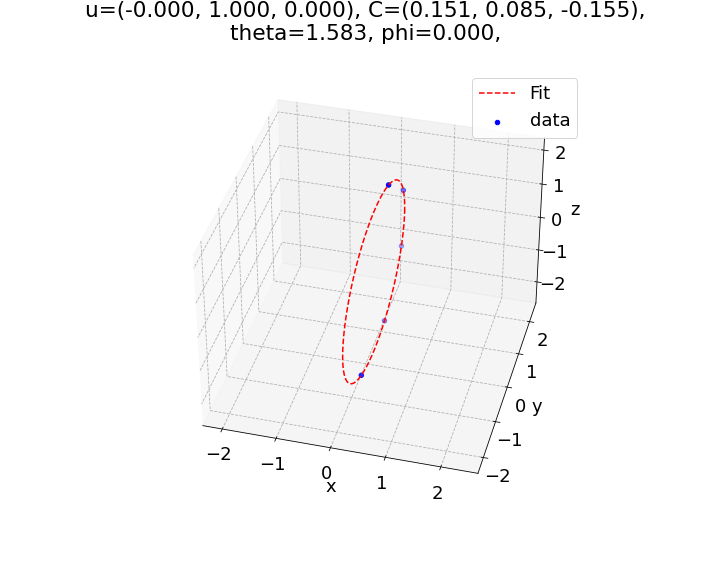

In [204]:
fig, ax = myCircleFitter.plot_results_3D()

In [205]:
myCircleFitter.final_results

{'r': 2.194062914412676,
 'n': array([ 9.99922035e-01,  2.14943324e-04, -1.24851195e-02]),
 'u': array([-2.14960078e-04,  9.99999977e-01,  0.00000000e+00]),
 'C': array([ 0.15081158,  0.08452787, -0.15467829]),
 'theta': 1.5832817706567872,
 'phi': 0.00021496007995191368}

In [206]:
norm_v_all = np.array([i for i in df_g.norm_v.values])
centroid_all = np.array([i for i in df_g.centroid.values])

In [207]:
np.mean(centroid_all, axis=0)

array([ 0.1515438 , -0.04831832, -0.0449064 ])

In [208]:
inch_to_mm(myCircleFitter.final_results['C'])

array([ 3.83061425,  2.14700778, -3.92882847])

In [209]:
inch_to_mm(np.mean(centroid_all, axis=0))

array([ 3.84921252, -1.22728533, -1.14062256])

In [210]:
inch_to_mm(myCircleFitter.final_results['C'][0] - np.mean(centroid_all, axis=0)[0])

-0.018598267329701205

In [211]:
centroid_all

array([[ 0.1536448,  0.3121826,  0.1213228],
       [ 0.1546226,  0.050629 ,  0.2011982],
       [ 0.152989 , -0.1905768,  0.0727624],
       [ 0.1498142, -0.2712564, -0.1891456],
       [ 0.1466484, -0.14257  , -0.4306698]])

In [212]:
np.mean(norm_v_all, axis=0), np.std(norm_v_all, axis=0, ddof=1)

(array([ 9.99924495e-01,  2.88107308e-04, -1.22750137e-02]),
 array([3.33394976e-06, 4.86154864e-04, 2.66751268e-04]))

In [213]:
mean_norm_v = np.mean(norm_v_all, axis=0)

In [214]:
phi = np.arctan2(mean_norm_v[1], mean_norm_v[0])
theta = np.arccos(mean_norm_v[2])
phi, theta

(0.0002881290556837588, 1.5830716487796528)

In [215]:
points = ['A', 'B', 'C', 'D', 'E']

for point in points:
    print(point)
    df_m_ = df_m.query(f'Point == "{point}"').copy()
    myCircleFitter = CircleFitter3D()
    print(myCircleFitter.run_fit(df_m_, flip_condition_index=0, flip_condition='<0'))

A
{'r': 2.1233226641731497, 'n': array([ 9.99921099e-01,  2.31476281e-04, -1.25595545e-02]), 'u': array([-2.31494540e-04,  9.99999973e-01,  0.00000000e+00]), 'C': array([ 0.14949886,  0.08503345, -0.15485135]), 'theta': 1.5833562115357604, 'phi': 0.0002314945424718796}
B
{'r': 2.105599077290435, 'n': array([ 9.99922316e-01,  1.97838299e-04, -1.24628494e-02]), 'u': array([-1.97853665e-04,  9.99999980e-01,  0.00000000e+00]), 'C': array([ 0.15028493,  0.08474739, -0.1547886 ]), 'theta': 1.5832594988314899, 'phi': 0.00019785366649620385}
C
{'r': 1.4403987041733897, 'n': array([ 9.99921459e-01,  2.90230618e-04, -1.25296404e-02]), 'u': array([-2.90253403e-04,  9.99999958e-01,  0.00000000e+00]), 'C': array([ 0.14889868,  0.08499615, -0.1545403 ]), 'theta': 1.583326295052281, 'phi': 0.0002902534071073804}
D
{'r': 2.194062914412676, 'n': array([ 9.99922035e-01,  2.14943324e-04, -1.24851195e-02]), 'u': array([-2.14960078e-04,  9.99999977e-01,  0.00000000e+00]), 'C': array([ 0.15081158,  0.084527

## SmarAct1, at SmarAct2 Home

In [216]:
df_groups.SmarAct2_Meas_Deg.unique()

array([346.999992, 346.999993, 347.000003, 346.999998, 347.000004,
       346.999999, 346.999996, 346.999989, 347.000001, 348.      ,
       348.999997, 349.999995, 354.999996, 359.999999,  14.999997,
        29.999999,  59.999994,  89.999992, 134.999995, 180.      ,
       224.999994, 269.999988, 314.999999, 346.999995, 346.999994,
       347.      , 359.999997, 359.999993,  89.999999,  89.999998,
       179.999996, 179.999997, 269.999992, 269.999995, 346.99999 ,
       347.999998, 349.999996, 359.999994,  89.999996,  89.999989,
       134.999997, 346.999997])

In [217]:
sorted(df_groups.SmarAct2_Meas_Deg.unique())

[14.999997,
 29.999999,
 59.999994,
 89.999989,
 89.999992,
 89.999996,
 89.999998,
 89.999999,
 134.999995,
 134.999997,
 179.999996,
 179.999997,
 180.0,
 224.999994,
 269.999988,
 269.999992,
 269.999995,
 314.999999,
 346.999989,
 346.99999,
 346.999992,
 346.999993,
 346.999994,
 346.999995,
 346.999996,
 346.999997,
 346.999998,
 346.999999,
 347.0,
 347.000001,
 347.000003,
 347.000004,
 347.999998,
 348.0,
 348.999997,
 349.999995,
 349.999996,
 354.999996,
 359.999993,
 359.999994,
 359.999997,
 359.999999]

In [218]:
map_ax2_home = (df_groups.SmarAct2_Meas_Deg >= 346.999) & \
(df_groups.SmarAct2_Meas_Deg <= 347.001) & \
(~np.array([True if 'Repeat' in i else False for i in df_groups.Group]))\
& ((df_groups.SmarAct1_Meas_Deg > 350.) | (df_groups.SmarAct1_Meas_Deg < 5.))\
& (df_groups.Group_Index >= 45) & (df_groups.Group_Index < 69)
#### & (df_groups.Group_Index > 20) & (df_groups.Group_Index < 69)\
# & (df_groups.Group_Index <= 20)
# & (df_groups.index > "12-07-22 13:00")
df_g = df_groups[map_ax2_home].copy()
df_m = df_meas[np.isin(df_meas.Group_Index, df_g.Group_Index)].copy()

In [219]:
df_m

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,Group,Group_Index,Datetime
0,A,0.051971,1.160427,-1.985804,1.320063,29.474846,-50.439422,Black Plate Horizontal Rotation 2 Degrees,45,2022-12-07 13:39:23
1,B,0.174310,-0.598436,-2.144312,4.427474,-15.200274,-54.465525,Black Plate Horizontal Rotation 2 Degrees,45,2022-12-07 13:39:23
2,C,0.245352,-1.324411,-0.406885,6.231941,-33.640039,-10.334879,Black Plate Horizontal Rotation 2 Degrees,45,2022-12-07 13:39:23
3,D,0.201308,-0.236700,2.014549,5.113223,-6.012180,51.169545,Black Plate Horizontal Rotation 2 Degrees,45,2022-12-07 13:39:23
4,E,0.074047,1.218060,-0.023171,1.880794,30.938724,-0.588543,Black Plate Horizontal Rotation 2 Degrees,45,2022-12-07 13:39:23
0,A,0.014907,1.159620,-1.985367,0.378638,29.454348,-50.428322,Black Plate Horizontal Rotation 4 Degrees,46,2022-12-07 13:42:48
1,B,0.198521,-0.593889,-2.144588,5.042433,-15.084781,-54.472535,Black Plate Horizontal Rotation 4 Degrees,46,2022-12-07 13:42:48
2,C,0.294827,-1.316333,-0.407455,7.488606,-33.434858,-10.349357,Black Plate Horizontal Rotation 4 Degrees,46,2022-12-07 13:42:48
3,D,0.212820,-0.232966,2.014495,5.405628,-5.917336,51.168173,Black Plate Horizontal Rotation 4 Degrees,46,2022-12-07 13:42:48
4,E,0.034873,1.217239,-0.022721,0.885774,30.917871,-0.577113,Black Plate Horizontal Rotation 4 Degrees,46,2022-12-07 13:42:48


In [220]:
map_ax2_home.sum()

4

In [221]:
df_g

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-07 13:39:23,Black Plate Horizontal Rotation 2 Degrees,12-07-22 13:39:23,101178.0,False,2.000000,346.999995,0.034907,6.056292,45,True,...,-0.020439,0.110440,-0.993673,"[0.06772544728409961, -0.9914444333999352, -0....",0.067725,-0.991444,-0.111585,0.059201,3.391948,0.008630
2022-12-07 13:42:48,Black Plate Horizontal Rotation 4 Degrees,12-07-22 13:42:48,101383.0,False,3.999997,346.999994,0.069813,6.056292,46,True,...,-0.024266,0.110126,-0.993621,"[0.10231653055391492, -0.9884212241079839, -0....",0.102317,-0.988421,-0.112048,0.094136,5.393575,0.010047
2022-12-07 14:52:21,Black Plate Horizontal Rotation 4 Degrees Check,12-07-22 14:52:21,105556.0,False,4.000003,346.999990,0.069813,6.056292,58,True,...,-0.024246,0.110087,-0.993626,"[0.10261278825025585, -0.9883946458491185, -0....",0.102613,-0.988395,-0.112012,0.094424,5.410090,0.009359
2022-12-07 14:55:45,Black Plate Horizontal Rotation -8 Degrees Check,12-07-22 14:55:45,105760.0,False,351.999992,346.999996,6.143559,6.056292,59,True,...,-0.001267,0.110521,-0.993873,"[-0.1052159680286301, -0.9883718700386369, -0....",-0.105216,-0.988372,-0.109775,0.115085,6.593856,0.017627


In [222]:
len(df_groups)

82

In [223]:
len(df_meas), len(df_m)

(410, 20)

In [278]:
#point = 'E'
# point = 'C'
# df_m_ = df_m.query(f'Point == "{point}"').copy()
# multiple points
# points = ['A', 'B']
points = ['A']
# points = ['E']
df_m_ = df_m[np.isin(df_m.Point, points)].copy()

In [279]:
len(df_m_)

4

In [280]:
df_m_

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,Group,Group_Index,Datetime
0,A,0.051971,1.160427,-1.985804,1.320063,29.474846,-50.439422,Black Plate Horizontal Rotation 2 Degrees,45,2022-12-07 13:39:23
0,A,0.014907,1.159620,-1.985367,0.378638,29.454348,-50.428322,Black Plate Horizontal Rotation 4 Degrees,46,2022-12-07 13:42:48
0,A,0.014863,1.159408,-1.985414,0.377520,29.448963,-50.429516,Black Plate Horizontal Rotation 4 Degrees Check,58,2022-12-07 14:52:21
1,A,0.237023,1.144558,-1.987693,6.020384,29.071773,-50.487402,Black Plate Horizontal Rotation -8 Degrees Check,59,2022-12-07 14:55:45


In [281]:
1.5**2

2.25

<IPython.core.display.Javascript object>


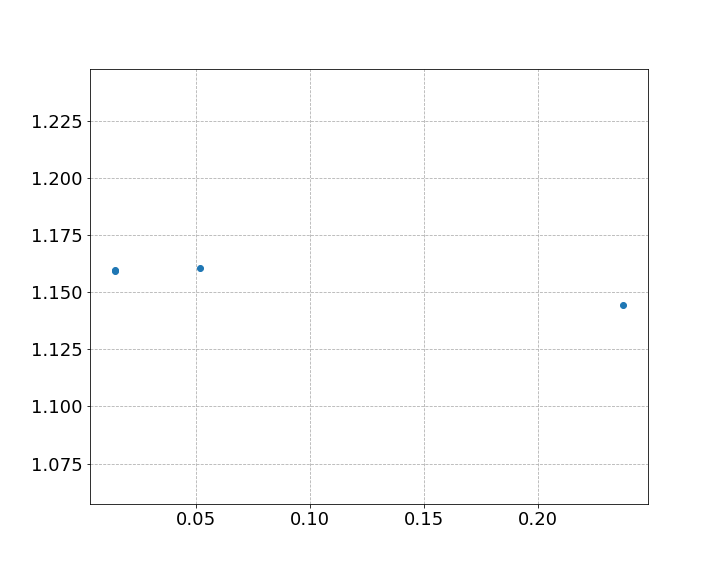

In [282]:
fig, ax = plt.subplots()

ax.scatter(df_m_.X, df_m_.Y)
ax.axis('equal');

In [283]:
df_g

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-07 13:39:23,Black Plate Horizontal Rotation 2 Degrees,12-07-22 13:39:23,101178.0,False,2.000000,346.999995,0.034907,6.056292,45,True,...,-0.020439,0.110440,-0.993673,"[0.06772544728409961, -0.9914444333999352, -0....",0.067725,-0.991444,-0.111585,0.059201,3.391948,0.008630
2022-12-07 13:42:48,Black Plate Horizontal Rotation 4 Degrees,12-07-22 13:42:48,101383.0,False,3.999997,346.999994,0.069813,6.056292,46,True,...,-0.024266,0.110126,-0.993621,"[0.10231653055391492, -0.9884212241079839, -0....",0.102317,-0.988421,-0.112048,0.094136,5.393575,0.010047
2022-12-07 14:52:21,Black Plate Horizontal Rotation 4 Degrees Check,12-07-22 14:52:21,105556.0,False,4.000003,346.999990,0.069813,6.056292,58,True,...,-0.024246,0.110087,-0.993626,"[0.10261278825025585, -0.9883946458491185, -0....",0.102613,-0.988395,-0.112012,0.094424,5.410090,0.009359
2022-12-07 14:55:45,Black Plate Horizontal Rotation -8 Degrees Check,12-07-22 14:55:45,105760.0,False,351.999992,346.999996,6.143559,6.056292,59,True,...,-0.001267,0.110521,-0.993873,"[-0.1052159680286301, -0.9883718700386369, -0....",-0.105216,-0.988372,-0.109775,0.115085,6.593856,0.017627


In [284]:
param_settings = {
                'A0': 0., 'Amin': None, 'Amax': None,
                'B0': 0., 'Bmin': None, 'Bmax': None,
                'R20': 4., 'R2min': 0., 'R2max': 10.,
            }

In [285]:
myCircleFitter = CircleFitter3D()
myCircleFitter.run_fit(df_m_, flip_condition_index=2, flip_condition='<0', param_settings=param_settings)

{'r': 1.0099907091717546,
 'n': array([0.01089493, 0.00790852, 0.99990937]),
 'u': array([-0.58743973,  0.80926792,  0.        ]),
 'C': array([ 0.05862009,  0.1504958 , -1.97788711]),
 'theta': 0.013463106080879722,
 'phi': 0.6278915060349846}

In [286]:
result_SmarAct1 = myCircleFitter.final_results

In [287]:
np.degrees(np.arccos(np.dot(result_SmarAct1['n'], result_SmarAct2['n'])))

90.09099758652597

In [288]:
result_SmarAct1['C'], result_SmarAct2['C']

(array([ 0.05862009,  0.1504958 , -1.97788711]),
 array([ 0.15081158,  0.08452787, -0.15467829]))

In [289]:
# REF
def circle_3d(t, **params):
    # t must be a scalar
    return params['r'] * np.cos(t) * params['u'] + params['r'] * np.sin(t) * np.cross(params['n'], params['u']) + params['C']

In [290]:
def fit_circle_v2(CircleFitter3D, param_settings):
    model = lm.Model(circle_3d, independent_vars=['t'])

<IPython.core.display.Javascript object>


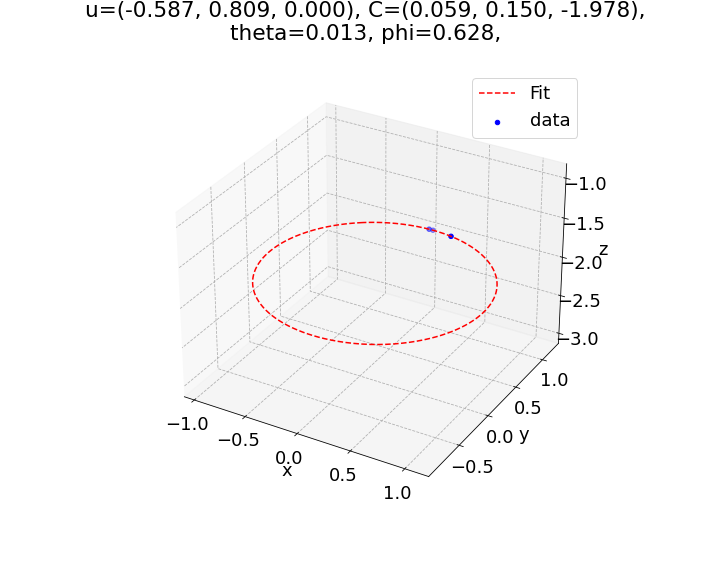

In [291]:
fig, ax = myCircleFitter.plot_results_3D()

In [292]:
np.degrees(np.arccos(np.dot(result_SmarAct1['n'], result_SmarAct2['n'])))

90.09099758652597

In [295]:
# plot both axes
point_min_1 = result_SmarAct1['C'] - 2. * result_SmarAct1['n']
point_plus_1 = result_SmarAct1['C'] + 6. * result_SmarAct1['n']
line_1 = np.array([[point_min_1[i], point_plus_1[i]] for i in range(3)])
point_min_2 = result_SmarAct2['C'] - 4. * result_SmarAct2['n']
point_plus_2 = result_SmarAct2['C'] + 4. * result_SmarAct2['n']
line_2 = np.array([[point_min_2[i], point_plus_2[i]] for i in range(3)])

<IPython.core.display.Javascript object>


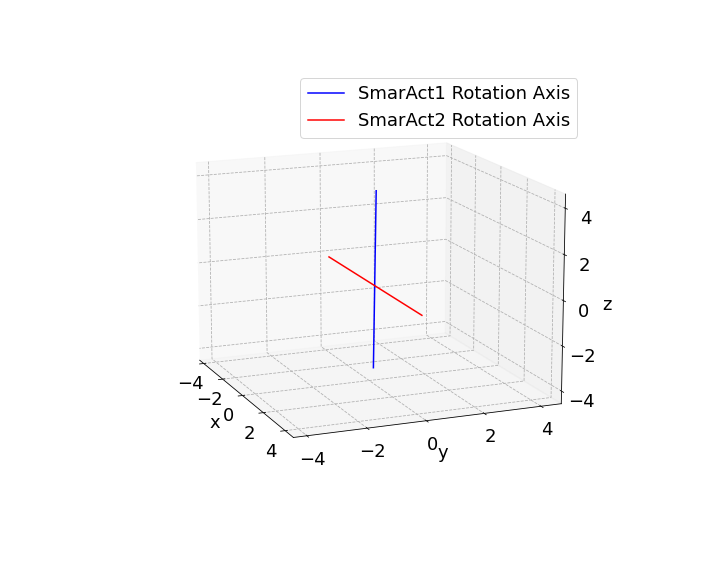

In [296]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(*line_1, color='blue', label='SmarAct1 Rotation Axis')
ax.plot(*line_2, color='red', label='SmarAct2 Rotation Axis')
# plot cube of points to get correct aspect ratio
vecs_all = np.concatenate([line_1.T, line_2.T])
ranges = np.ptp(vecs_all, axis=0)
mins = np.min(vecs_all, axis=0)
maxrange = np.max(ranges)
cens = mins + ranges/2
p_x = [cens[0]-maxrange/2, cens[0]-maxrange/2, cens[0]-maxrange/2, cens[0]-maxrange/2,
       cens[0]+maxrange/2, cens[0]+maxrange/2, cens[0]+maxrange/2, cens[0]+maxrange/2,]
p_y = [cens[1]-maxrange/2, cens[1]-maxrange/2, cens[1]+maxrange/2, cens[1]+maxrange/2,
       cens[1]-maxrange/2, cens[1]-maxrange/2, cens[1]+maxrange/2, cens[1]+maxrange/2,]
p_z = [cens[2]-maxrange/2, cens[2]+maxrange/2, cens[2]-maxrange/2, cens[2]+maxrange/2,
       cens[2]-maxrange/2, cens[2]+maxrange/2, cens[2]-maxrange/2, cens[2]+maxrange/2,]
ax.scatter3D(p_x, p_y, p_z, alpha=0.0)

# formatting
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend();

In [55]:
df_g

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-07 09:27:44,Black Plate Horizontal Rotation -4 Degrees B,12-07-22 09:27:44,86079.0,False,355.999992,346.999998,6.213372,6.056292,25,True,...,-0.009340,0.135376,-0.990750,"[-0.03531366853378591, -0.9902201420767217, -0...",-0.035314,-0.990220,-0.134970,0.044173,2.530945,0.005238
2022-12-07 09:30:56,Black Plate Horizontal Rotation -6 Degrees B,12-07-22 09:30:56,86271.0,False,353.999992,346.999998,6.178465,6.056292,26,True,...,-0.004721,0.135222,-0.990804,"[-0.06987472759839858, -0.9884379575262093, -0...",-0.069875,-0.988438,-0.134566,0.079092,4.531628,0.008307
2022-12-07 09:35:58,Black Plate Horizontal Rotation -8 Degrees B,12-07-22 09:35:58,86573.0,False,352.000004,346.999998,6.143559,6.056292,27,True,...,-0.000102,0.134894,-0.990860,"[-0.10436740248931989, -0.9854501818484654, -0...",-0.104367,-0.985450,-0.134147,0.114026,6.533233,0.011424
2022-12-07 09:42:26,Black Plate Horizontal Rotation -10 Degrees B,12-07-22 09:42:26,86961.0,False,349.999991,346.999998,6.108652,6.056292,28,True,...,0.004513,0.134437,-0.990912,"[-0.13869653554096945, -0.9812602770226109, -0...",-0.138697,-0.981260,-0.133759,0.148924,8.532702,0.014552
2022-12-07 09:47:40,Black Plate Horizontal Rotation -0 Degrees B,12-07-22 09:47:40,87275.0,False,358.000005,346.999992,6.248279,6.056292,29,True,...,-0.013996,0.135375,-0.990696,"[-0.0007057781360396297, -0.9907937236776829, ...",-0.000706,-0.990794,-0.135378,0.009245,0.529710,0.002772
2022-12-07 13:32:36,Black Plate Horizontal Rotation 0 Degrees,12-07-22 13:32:36,100771.0,False,359.999994,346.999999,6.283185,6.056292,44,True,...,-0.016594,0.110713,-0.993714,"[0.03305940337902522, -0.9932465826622602, -0....",0.033059,-0.993247,-0.111213,0.024292,1.391820,0.008581
2022-12-07 13:39:23,Black Plate Horizontal Rotation 2 Degrees,12-07-22 13:39:23,101178.0,False,2.000000,346.999995,0.034907,6.056292,45,True,...,-0.020439,0.110440,-0.993673,"[0.06772544728409961, -0.9914444333999352, -0....",0.067725,-0.991444,-0.111585,0.059201,3.391948,0.008630
2022-12-07 13:42:48,Black Plate Horizontal Rotation 4 Degrees,12-07-22 13:42:48,101383.0,False,3.999997,346.999994,0.069813,6.056292,46,True,...,-0.024266,0.110126,-0.993621,"[0.10231653055391492, -0.9884212241079839, -0....",0.102317,-0.988421,-0.112048,0.094136,5.393575,0.010047
2022-12-07 13:45:43,Black Plate Horizontal Rotation 6 Degrees,12-07-22 13:45:43,101558.0,False,5.874619,347.000000,0.102531,6.056293,47,True,...,-0.027841,0.109738,-0.993571,"[0.13464563674458577, -0.9844859979091052, -0....",0.134646,-0.984486,-0.112507,0.126906,7.271167,0.012354


In [80]:
norm_v_all = np.array([i for i in df_g.norm_v.values])
centroid_all = np.array([i for i in df_g.centroid.values])

In [81]:
centroid_all

array([[ 0.1575434,  0.0340682, -0.510343 ],
       [ 0.1567362,  0.0326308, -0.5103626],
       [ 0.1558478,  0.0312498, -0.5103498],
       [ 0.1549402,  0.0299594, -0.5103442],
       [ 0.1539534,  0.0286836, -0.5103188],
       [ 0.153006 ,  0.0273782, -0.5103282],
       [ 0.1520644,  0.0261118, -0.5103154],
       [ 0.151053 ,  0.02486  , -0.5103056]])

In [82]:
np.mean(norm_v_all, axis=0), np.std(norm_v_all, axis=0, ddof=1)

(array([ 0.99671635, -0.06882704, -0.0148461 ]),
 array([3.03831367e-03, 4.26394425e-02, 9.30843419e-05]))

In [83]:
mean_norm_v = np.mean(norm_v_all, axis=0)

In [84]:
phi = np.arctan2(mean_norm_v[1], mean_norm_v[0])
theta = np.arccos(mean_norm_v[2])
phi, theta

(-0.06894434416228898, 1.5856429722989254)

In [85]:
points = ['A', 'B', 'C', 'D', 'E']

for point in points:
    print(point)
    df_m_ = df_m.query(f'Point == "{point}"').copy()
    myCircleFitter = CircleFitter3D()
    print(myCircleFitter.run_fit(df_m_, flip_condition_index=0, flip_condition='<0'))

A
{'r': 1.131507402210906, 'n': array([ 0.01227308, -0.00288411,  0.99992052]), 'u': array([0.22876287, 0.97348218, 0.        ]), 'C': array([[ 0.05828937,  0.0624081 , -1.96133676]]), 'theta': 0.012607735095273742, 'phi': -0.23080666232339866}
B
{'r': 0.6452076838359313, 'n': array([ 0.0127505 , -0.00586233,  0.99990152]), 'u': array([0.41773511, 0.90856886, 0.        ]), 'C': array([[ 0.05955061,  0.07329486, -2.15587981]]), 'theta': 0.01403406802950836, 'phi': -0.4309510736540334}
C
{'r': 1.3668471618914624, 'n': array([0.01268648, 0.00209805, 0.99991732]), 'u': array([-0.16316107,  0.98659945,  0.        ]), 'C': array([[ 0.07970567,  0.02535209, -0.4436675 ]]), 'theta': 0.012859147541343973, 'phi': 0.1638938122479934}
D
{'r': 0.3877313344103003, 'n': array([ 0.02199227, -0.07836331,  0.99668226]), 'u': array([0.96280259, 0.27020578, 0.        ]), 'C': array([[0.11207911, 0.06719899, 2.0370342 ]]), 'theta': 0.08148096488047418, 'phi': -1.2971895720767705}
E
{'r': 1.174306485065178,

## SmarAct1, at SmarAct2 with 180 sweeps

In [78]:
df_groups_both = df_groups[np.array([True if 'Horizontal' in g else False for g in df_groups.Group]) & \
                           np.array([True if 'Vertical' in g else False for g in df_groups.Group])].copy()
df_meas_both = df_meas[np.isin(df_meas.Group_Index, df_groups_both.Group_Index)].copy()

In [79]:
df_groups_both

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-07 13:53:44,Horizontal -5 Degrees Vertical 0 Degrees,12-07-22 13:53:44,102039.0,False,355.000006,359.999997,6.195919,6.283185,48,True,...,0.005105,0.331180,-0.943554,"[-0.05367507307174795, -0.9421150647734756, -0...",-0.053675,-0.942115,-0.330966,0.062826,3.599649,0.077670
2022-12-07 14:00:38,Horizontal -10 Degrees Vertical 0 Degrees,12-07-22 14:00:38,102453.0,False,350.072969,359.999993,6.109926,6.283185,49,True,...,0.033392,0.328591,-0.943882,"[-0.13447054206159104, -0.9343441076684076, -0...",-0.134471,-0.934344,-0.330028,0.148844,8.528126,0.070914
2022-12-07 14:07:57,Horizontal -5 Degrees Vertical 90 Degrees,12-07-22 14:07:57,102892.0,False,354.999988,89.999999,6.195919,1.570796,50,True,...,0.052970,0.942172,0.330918,"[0.005126143854554968, 0.3311225292602116, -0....",0.005126,0.331123,-0.943574,0.062237,3.565892,0.557694
2022-12-07 14:13:36,Horizontal -10 Degrees Vertical 90 Degrees,12-07-22 14:13:36,103231.0,False,350.072409,89.999998,6.109916,1.570796,51,True,...,0.133798,0.934413,0.330108,"[0.03332530500606637, 0.32867181059664163, -0....",0.033325,0.328672,-0.943856,0.148269,8.495191,0.551930
2022-12-07 14:20:30,Horizontal -5 Degrees Vertical 180 Degrees,12-07-22 14:20:30,103645.0,False,354.999997,179.999996,6.195919,3.141593,52,True,...,-0.005669,-0.330806,0.943682,"[0.052934570707892405, 0.9422743686325299, 0.3...",0.052935,0.942274,0.330631,0.062274,3.568043,0.711310
2022-12-07 14:25:42,Horizontal -10 Degrees Vertical 180 Degrees,12-07-22 14:25:42,103957.0,False,350.072509,179.999997,6.109918,3.141593,53,True,...,-0.033904,-0.328276,0.943973,"[0.133753020161418, 0.9345291544156902, 0.3297...",0.133753,0.934529,0.329796,0.148280,8.495814,0.711334
2022-12-07 14:30:11,Horizontal -5 Degrees Vertical 270,12-07-22 14:30:11,104226.0,False,354.999993,269.999992,6.195919,4.712389,54,True,...,-0.053573,-0.942169,-0.330828,"[-0.005682274295836929, -0.3310103637032631, 0...",-0.005682,-0.331010,0.943610,0.062812,3.598871,0.448888
2022-12-07 14:33:28,Horizontal -10 Degrees Vertical 270,12-07-22 14:33:28,104423.0,False,350.073606,269.999995,6.109937,4.712389,55,True,...,-0.134340,-0.934370,-0.330008,"[-0.03391020165894417, -0.32849664811830753, 0...",-0.033910,-0.328497,0.943896,0.148769,8.523850,0.454214
2022-12-08 09:58:28,Horizontal -5 Degrees Vertical 0 Degrees C,12-08-22 09:58:28,174323.0,False,355.000000,359.999994,6.195919,6.283185,83,True,...,0.000443,0.334580,-0.942367,"[-0.043060894494399926, -0.9414869231679919, -...",-0.043061,-0.941487,-0.334287,0.051199,2.933482,0.069291


In [80]:
df_meas_both

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,Group,Group_Index,Datetime
0,A,0.205518,1.536562,-1.698875,5.220157,39.028675,-43.151425,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
1,B,0.111833,-0.143756,-2.247990,2.840558,-3.651402,-57.098946,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
2,C,0.072486,-1.243120,-0.717905,1.841144,-31.575248,-18.234787,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
3,D,0.134063,-0.726213,1.885861,3.405200,-18.445810,47.900869,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
4,E,0.211237,1.150933,0.226553,5.365420,29.233698,5.754446,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
0,A,0.329257,1.518438,-1.700253,8.363128,38.568325,-43.186426,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38
1,B,0.091458,-0.147995,-2.247843,2.323033,-3.759073,-57.095212,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38
2,C,-0.041903,-1.238480,-0.716705,-1.064336,-31.457392,-18.204307,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38
3,D,0.064234,-0.726220,1.886610,1.631544,-18.445988,47.919894,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38
4,E,0.302152,1.135714,0.225536,7.674661,28.847136,5.728614,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38


In [82]:
df_groups_both.SmarAct2_Meas_Deg.unique()

array([359.999997, 359.999993,  89.999999,  89.999998, 179.999996,
       179.999997, 269.999992, 269.999995, 359.999994,  89.999989])

In [83]:
sorted(df_groups_both.SmarAct2_Meas_Deg.unique())

[89.999989,
 89.999998,
 89.999999,
 179.999996,
 179.999997,
 269.999992,
 269.999995,
 359.999993,
 359.999994,
 359.999997]

In [84]:
map_ax2_home = ((df_groups_both.SmarAct2_Meas_Deg >= 359.999) | ((df_groups_both.SmarAct2_Meas_Deg >= 179.999) & (df_groups_both.SmarAct2_Meas_Deg <= 180.000))) & \
(~np.array([True if 'Repeat' in i else False for i in df_groups_both.Group]))#\
#& ()
# & (df_groups.Group_Index > 20) & (df_groups.Group_Index < 69)\
# & ((df_groups.SmarAct1_Meas_Deg > 350.) | (df_groups.SmarAct1_Meas_Deg < 5.))
# & (df_groups.Group_Index <= 20)
# & (df_groups.index > "12-07-22 13:00")
df_g = df_groups_both[map_ax2_home].copy()
df_m = df_meas[np.isin(df_meas.Group_Index, df_g.Group_Index)].copy()

In [85]:
df_m

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,Group,Group_Index,Datetime
0,A,0.205518,1.536562,-1.698875,5.220157,39.028675,-43.151425,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
1,B,0.111833,-0.143756,-2.247990,2.840558,-3.651402,-57.098946,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
2,C,0.072486,-1.243120,-0.717905,1.841144,-31.575248,-18.234787,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
3,D,0.134063,-0.726213,1.885861,3.405200,-18.445810,47.900869,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
4,E,0.211237,1.150933,0.226553,5.365420,29.233698,5.754446,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
0,A,0.329257,1.518438,-1.700253,8.363128,38.568325,-43.186426,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38
1,B,0.091458,-0.147995,-2.247843,2.323033,-3.759073,-57.095212,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38
2,C,-0.041903,-1.238480,-0.716705,-1.064336,-31.457392,-18.204307,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38
3,D,0.064234,-0.726220,1.886610,1.631544,-18.445988,47.919894,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38
4,E,0.302152,1.135714,0.225536,7.674661,28.847136,5.728614,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38


In [86]:
map_ax2_home.sum()

5

In [87]:
df_g

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-07 13:53:44,Horizontal -5 Degrees Vertical 0 Degrees,12-07-22 13:53:44,102039.0,False,355.000006,359.999997,6.195919,6.283185,48,True,...,0.005105,0.331180,-0.943554,"[-0.05367507307174795, -0.9421150647734756, -0...",-0.053675,-0.942115,-0.330966,0.062826,3.599649,0.077670
2022-12-07 14:00:38,Horizontal -10 Degrees Vertical 0 Degrees,12-07-22 14:00:38,102453.0,False,350.072969,359.999993,6.109926,6.283185,49,True,...,0.033392,0.328591,-0.943882,"[-0.13447054206159104, -0.9343441076684076, -0...",-0.134471,-0.934344,-0.330028,0.148844,8.528126,0.070914
2022-12-07 14:20:30,Horizontal -5 Degrees Vertical 180 Degrees,12-07-22 14:20:30,103645.0,False,354.999997,179.999996,6.195919,3.141593,52,True,...,-0.005669,-0.330806,0.943682,"[0.052934570707892405, 0.9422743686325299, 0.3...",0.052935,0.942274,0.330631,0.062274,3.568043,0.711310
2022-12-07 14:25:42,Horizontal -10 Degrees Vertical 180 Degrees,12-07-22 14:25:42,103957.0,False,350.072509,179.999997,6.109918,3.141593,53,True,...,-0.033904,-0.328276,0.943973,"[0.133753020161418, 0.9345291544156902, 0.3297...",0.133753,0.934529,0.329796,0.148280,8.495814,0.711334
2022-12-08 09:58:28,Horizontal -5 Degrees Vertical 0 Degrees C,12-08-22 09:58:28,174323.0,False,355.000000,359.999994,6.195919,6.283185,83,True,...,0.000443,0.334580,-0.942367,"[-0.043060894494399926, -0.9414869231679919, -...",-0.043061,-0.941487,-0.334287,0.051199,2.933482,0.069291


In [88]:
len(df_groups)

82

In [89]:
len(df_meas), len(df_m)

(410, 25)

In [104]:
# point = 'D'
#point = 'E'
# point = 'C'
#df_m_ = df_m.query(f'Point == "{point}"').copy()
df_m_ = df_m.copy()

In [105]:
len(df_m_)

5

In [106]:
df_m_

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,Group,Group_Index,Datetime
4,E,0.211237,1.150933,0.226553,5.365420,29.233698,5.754446,Horizontal -5 Degrees Vertical 0 Degrees,48,2022-12-07 13:53:44
4,E,0.302152,1.135714,0.225536,7.674661,28.847136,5.728614,Horizontal -10 Degrees Vertical 0 Degrees,49,2022-12-07 14:00:38
4,E,0.089280,-0.990524,-0.534929,2.267712,-25.159310,-13.587197,Horizontal -5 Degrees Vertical 180 Degrees,52,2022-12-07 14:20:30
0,E,-0.003297,-0.988060,-0.533942,-0.083744,-25.096724,-13.562127,Horizontal -10 Degrees Vertical 180 Degrees,53,2022-12-07 14:25:42
4,E,0.205566,1.141028,0.229877,5.221376,28.982111,5.838876,Horizontal -5 Degrees Vertical 0 Degrees C,83,2022-12-08 09:58:28


In [107]:
1.5**2

2.25

<IPython.core.display.Javascript object>


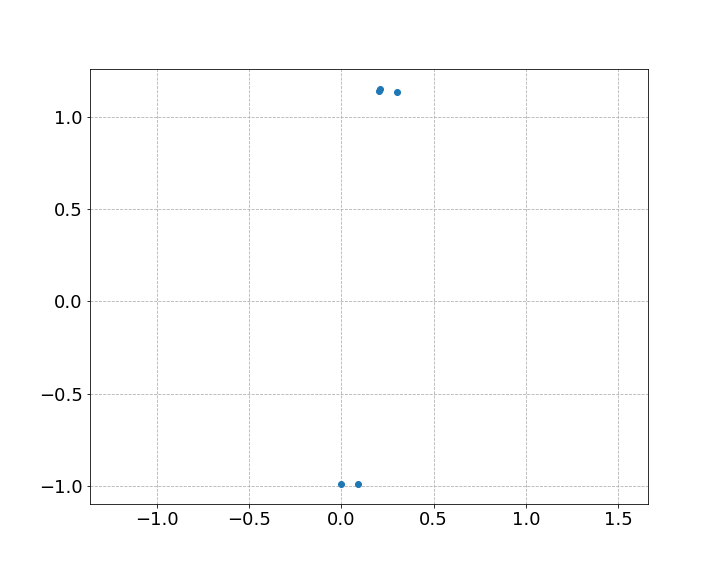

In [108]:
fig, ax = plt.subplots()

ax.scatter(df_m_.X, df_m_.Y)
ax.axis('equal');

In [109]:
df_g

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-07 13:53:44,Horizontal -5 Degrees Vertical 0 Degrees,12-07-22 13:53:44,102039.0,False,355.000006,359.999997,6.195919,6.283185,48,True,...,0.005105,0.331180,-0.943554,"[-0.05367507307174795, -0.9421150647734756, -0...",-0.053675,-0.942115,-0.330966,0.062826,3.599649,0.077670
2022-12-07 14:00:38,Horizontal -10 Degrees Vertical 0 Degrees,12-07-22 14:00:38,102453.0,False,350.072969,359.999993,6.109926,6.283185,49,True,...,0.033392,0.328591,-0.943882,"[-0.13447054206159104, -0.9343441076684076, -0...",-0.134471,-0.934344,-0.330028,0.148844,8.528126,0.070914
2022-12-07 14:20:30,Horizontal -5 Degrees Vertical 180 Degrees,12-07-22 14:20:30,103645.0,False,354.999997,179.999996,6.195919,3.141593,52,True,...,-0.005669,-0.330806,0.943682,"[0.052934570707892405, 0.9422743686325299, 0.3...",0.052935,0.942274,0.330631,0.062274,3.568043,0.711310
2022-12-07 14:25:42,Horizontal -10 Degrees Vertical 180 Degrees,12-07-22 14:25:42,103957.0,False,350.072509,179.999997,6.109918,3.141593,53,True,...,-0.033904,-0.328276,0.943973,"[0.133753020161418, 0.9345291544156902, 0.3297...",0.133753,0.934529,0.329796,0.148280,8.495814,0.711334
2022-12-08 09:58:28,Horizontal -5 Degrees Vertical 0 Degrees C,12-08-22 09:58:28,174323.0,False,355.000000,359.999994,6.195919,6.283185,83,True,...,0.000443,0.334580,-0.942367,"[-0.043060894494399926, -0.9414869231679919, -...",-0.043061,-0.941487,-0.334287,0.051199,2.933482,0.069291


In [110]:
param_settings = {
                'A0': 0., 'Amin': None, 'Amax': None,
                'B0': 0., 'Bmin': None, 'Bmax': None,
                'R20': 4., 'R2min': 1., 'R2max': 10.,
            }

In [111]:
myCircleFitter = CircleFitter3D()
myCircleFitter.run_fit(df_m_, flip_condition_index=2, flip_condition='<0', param_settings=param_settings)

{'r': 1.1375840415184866,
 'n': array([-0.0037113 , -0.33617565,  0.94179199]),
 'u': array([ 0.99993907, -0.0110391 ,  0.        ]),
 'C': array([ 0.10833181,  0.07934669, -0.15271698]),
 'theta': 0.34287500323808034,
 'phi': -1.5818356526756734}

In [112]:
# REF
def circle_3d(t, **params):
    # t must be a scalar
    return params['r'] * np.cos(t) * params['u'] + params['r'] * np.sin(t) * np.cross(params['n'], params['u']) + params['C']

In [113]:
def fit_circle_v2(CircleFitter3D, param_settings):
    model = lm.Model(circle_3d, independent_vars=['t'])

<IPython.core.display.Javascript object>


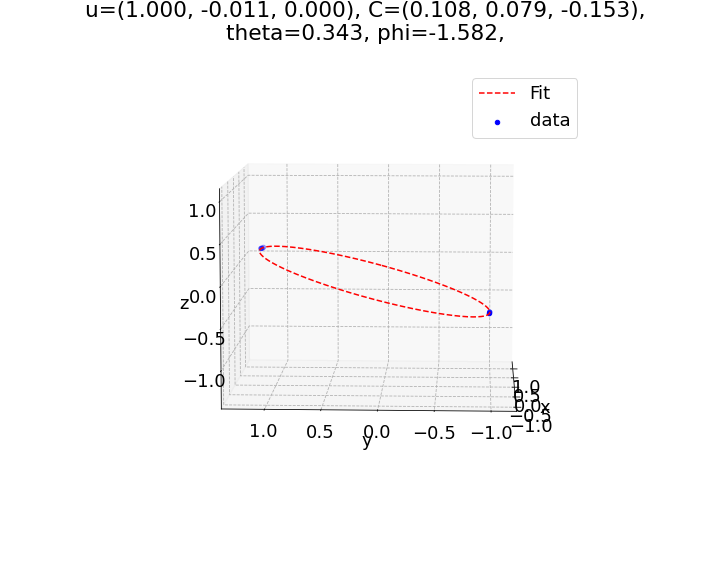

In [114]:
fig, ax = myCircleFitter.plot_results_3D()

In [115]:
df_g

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-07 13:53:44,Horizontal -5 Degrees Vertical 0 Degrees,12-07-22 13:53:44,102039.0,False,355.000006,359.999997,6.195919,6.283185,48,True,...,0.005105,0.331180,-0.943554,"[-0.05367507307174795, -0.9421150647734756, -0...",-0.053675,-0.942115,-0.330966,0.062826,3.599649,0.077670
2022-12-07 14:00:38,Horizontal -10 Degrees Vertical 0 Degrees,12-07-22 14:00:38,102453.0,False,350.072969,359.999993,6.109926,6.283185,49,True,...,0.033392,0.328591,-0.943882,"[-0.13447054206159104, -0.9343441076684076, -0...",-0.134471,-0.934344,-0.330028,0.148844,8.528126,0.070914
2022-12-07 14:20:30,Horizontal -5 Degrees Vertical 180 Degrees,12-07-22 14:20:30,103645.0,False,354.999997,179.999996,6.195919,3.141593,52,True,...,-0.005669,-0.330806,0.943682,"[0.052934570707892405, 0.9422743686325299, 0.3...",0.052935,0.942274,0.330631,0.062274,3.568043,0.711310
2022-12-07 14:25:42,Horizontal -10 Degrees Vertical 180 Degrees,12-07-22 14:25:42,103957.0,False,350.072509,179.999997,6.109918,3.141593,53,True,...,-0.033904,-0.328276,0.943973,"[0.133753020161418, 0.9345291544156902, 0.3297...",0.133753,0.934529,0.329796,0.148280,8.495814,0.711334
2022-12-08 09:58:28,Horizontal -5 Degrees Vertical 0 Degrees C,12-08-22 09:58:28,174323.0,False,355.000000,359.999994,6.195919,6.283185,83,True,...,0.000443,0.334580,-0.942367,"[-0.043060894494399926, -0.9414869231679919, -...",-0.043061,-0.941487,-0.334287,0.051199,2.933482,0.069291


In [80]:
norm_v_all = np.array([i for i in df_g.norm_v.values])
centroid_all = np.array([i for i in df_g.centroid.values])

In [81]:
centroid_all

array([[ 0.1575434,  0.0340682, -0.510343 ],
       [ 0.1567362,  0.0326308, -0.5103626],
       [ 0.1558478,  0.0312498, -0.5103498],
       [ 0.1549402,  0.0299594, -0.5103442],
       [ 0.1539534,  0.0286836, -0.5103188],
       [ 0.153006 ,  0.0273782, -0.5103282],
       [ 0.1520644,  0.0261118, -0.5103154],
       [ 0.151053 ,  0.02486  , -0.5103056]])

In [82]:
np.mean(norm_v_all, axis=0), np.std(norm_v_all, axis=0, ddof=1)

(array([ 0.99671635, -0.06882704, -0.0148461 ]),
 array([3.03831367e-03, 4.26394425e-02, 9.30843419e-05]))

In [83]:
mean_norm_v = np.mean(norm_v_all, axis=0)

In [84]:
phi = np.arctan2(mean_norm_v[1], mean_norm_v[0])
theta = np.arccos(mean_norm_v[2])
phi, theta

(-0.06894434416228898, 1.5856429722989254)

In [85]:
points = ['A', 'B', 'C', 'D', 'E']

for point in points:
    print(point)
    df_m_ = df_m.query(f'Point == "{point}"').copy()
    myCircleFitter = CircleFitter3D()
    print(myCircleFitter.run_fit(df_m_, flip_condition_index=0, flip_condition='<0'))

A
{'r': 1.131507402210906, 'n': array([ 0.01227308, -0.00288411,  0.99992052]), 'u': array([0.22876287, 0.97348218, 0.        ]), 'C': array([[ 0.05828937,  0.0624081 , -1.96133676]]), 'theta': 0.012607735095273742, 'phi': -0.23080666232339866}
B
{'r': 0.6452076838359313, 'n': array([ 0.0127505 , -0.00586233,  0.99990152]), 'u': array([0.41773511, 0.90856886, 0.        ]), 'C': array([[ 0.05955061,  0.07329486, -2.15587981]]), 'theta': 0.01403406802950836, 'phi': -0.4309510736540334}
C
{'r': 1.3668471618914624, 'n': array([0.01268648, 0.00209805, 0.99991732]), 'u': array([-0.16316107,  0.98659945,  0.        ]), 'C': array([[ 0.07970567,  0.02535209, -0.4436675 ]]), 'theta': 0.012859147541343973, 'phi': 0.1638938122479934}
D
{'r': 0.3877313344103003, 'n': array([ 0.02199227, -0.07836331,  0.99668226]), 'u': array([0.96280259, 0.27020578, 0.        ]), 'C': array([[0.11207911, 0.06719899, 2.0370342 ]]), 'theta': 0.08148096488047418, 'phi': -1.2971895720767705}
E
{'r': 1.174306485065178,

# Asides

## Circles in 3D

- Following this note: https://meshlogic.github.io/posts/jupyter/curve-fitting/fitting-a-circle-to-cluster-of-3d-points/

### Dev

In [30]:
def circle_3d(t, **params):
    # t must be a scalar
    return params['r'] * np.cos(t) * params['u'] + params['r'] * np.sin(t) * np.cross(params['n'], params['u']) + params['C']

In [31]:
#phi = np.pi/4.
# phi = -np.pi/2
# theta = np.pi/3.

# params = {
#     'r': 1.5,
#     'n': np.array([np.cos(phi) * np.sin(theta), np.sin(phi) * np.sin(theta), np.cos(theta)]),
#     'u': np.array([-np.sin(phi), np.cos(phi), 0.]),
#     'C': np.array([0., 0.5, 1.0])
# }

phi = -30/180*np.pi
theta = 45/180*np.pi

params = {
    'r': 2.5,
    'n': np.array([np.cos(phi) * np.sin(theta), np.sin(phi) * np.sin(theta), np.cos(theta)]),
    'u': np.array([-np.sin(phi), np.cos(phi), 0.]),
    'C': np.array([3., 3., 4.])
}

In [32]:
thetas = np.linspace(0, 2*np.pi, 100)
vecs = np.array([circle_3d(t, **params) for t in thetas])

In [33]:
vecs.shape

(100, 3)

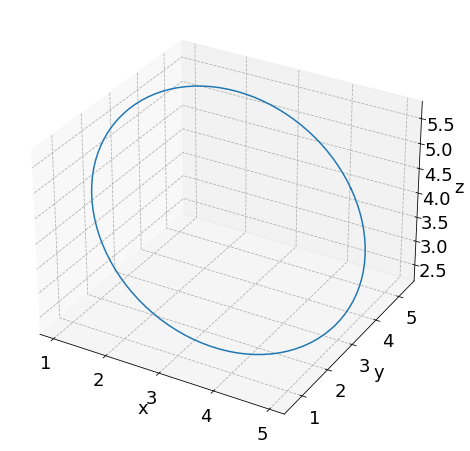

In [653]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(*vecs.T)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [654]:
params['n']

array([ 0.61237244, -0.35355339,  0.70710678])

In [655]:
np.linalg.norm(params['n'])

1.0

In [656]:
# generate some measurements
N = 50
#t_gen = np.random.uniform(low=0, high=np.pi/2, size=N)
#R_gen = params['r'] * (np.random.uniform(low=0.9, high=1.1, size=N))**(1/2)
#vecs_gen = []
#for i in range(len(t_gen)):
#     print(i)
#    params_ = deepcopy(params)
#    params_['r'] = R_gen[i]
#    vecs_gen.append(circle_3d(t_gen[i], **params_))
#vecs_gen = np.array(vecs_gen)
# attempt 2, just add noise to each uniform point
t_gen = np.linspace(0, np.radians(10), N)
# t_gen = np.linspace(0, np.radians(20), N)
#t_gen = np.linspace(0, 3*np.pi/4, N)
#t_gen = np.linspace(0, 3*np.pi/2, N)
# t_gen = np.linspace(0, 2*np.pi, N)
vecs_gen = np.array([circle_3d(t, **params) for t in t_gen])
# add noise?
# vecs_gen += np.random.normal(loc=0, scale=0.01, size=(N, 3))

In [657]:
vecs_gen.shape

(50, 3)

In [658]:
params

{'r': 2.5,
 'n': array([ 0.61237244, -0.35355339,  0.70710678]),
 'u': array([0.5      , 0.8660254, 0.       ]),
 'C': array([3., 3., 4.])}

In [659]:
#params_

In [660]:
#R_gen

In [661]:
#params_['r']

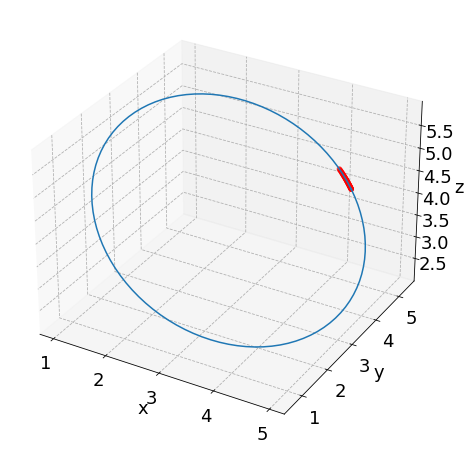

In [662]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(*vecs.T)
ax.scatter3D(*vecs_gen.T, color='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [663]:
df_cir = pd.DataFrame({'X': vecs_gen[:, 0], 'Y': vecs_gen[:, 1], 'Z': vecs_gen[:, 2]})

In [664]:
#df_cir

In [665]:
def plane_fit_SVD_circle(df):
    # collect positional points from dataframe
    points = df[['X','Y','Z']].values.T
    # subtract centroid
    centroid = (np.sum(points,axis=1) / len(df))
    points_c = points - centroid[:,None]
    # calculate svd
    u, _, _ = np.linalg.svd(points_c)
    # normal vector is left singular vector with least singular value
    norm_v = u[:,2]
    return norm_v, centroid

# circle fit
def calc_R(xc, yc, x, y):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def circ_alg_dist(center, x, y):
    Ri = calc_R(*center, x, y)
    return Ri - Ri.mean()

def reco_circle(x, y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_est = x_m, y_m
    center_fit, ier = optimize.leastsq(circ_alg_dist, center_est, args=(x, y))
    Ri_fit = calc_R(*center_fit, x, y)
    R_fit = np.mean(Ri_fit)
    R_residual = np.sum((Ri_fit - R_fit)**2)
    return center_fit, R_fit, Ri_fit, R_residual

# cent, R_guess, Ri_fit, R_residual = reco_circle(track_data_rot[1], track_data_rot[2])
# C_x_guess, C_y_guess = cent

def mod_circle(x, y, **params):
    return params['A'] * x + params['B'] * y + params['C'] - x**2 - y**2

def reco_circle_coope(x, y):
    model = lm.Model(mod_circle, independent_vars=['x', 'y'])
    params = lm.Parameters()
    params.add('A', value=np.mean(x)*2)
    params.add('B', value=np.mean(y)*2)
    params.add('C', value=6.3, min=3, max=9)
    result = model.fit(np.zeros_like(x), x=x, y=y, params=params)
    Xc = result.params['A'].value/2
    Yc = result.params['B'].value/2
    R = (result.params['C'].value - Xc**2 - Yc**2)**(1/2)
    result_params = {'Xc':Xc, 'Yc':Yc, 'R': R}
    return result_params, result

def mod_circle_v2(x, y, **params):
    return params['A'] * x + params['B'] * y + params['C']

def reco_circle_coope_v2(x, y):
    model = lm.Model(mod_circle_v2, independent_vars=['x', 'y'])
    params = lm.Parameters()
    params.add('A', value=0.)
    params.add('B', value=0.)
    params.add('R2', value=4., min=0)
    params.add('C', expr='R2 -(A/2)**2 - (B/2)**2')#, min=, max=9)
    result = model.fit(x**2 + y**2, x=x, y=y, params=params)
    Xc = result.params['A'].value/2
    Yc = result.params['B'].value/2
    #R = (result.params['C'].value - Xc**2 - Yc**2)**(1/2)
    R = (result.params['R2'].value)**(1/2)
    result_params = {'Xc':Xc, 'Yc':Yc, 'R': R}
    return result_params, result

In [666]:
# sketching circle fit
# first fit plane
# norm_v, centroid = plane_fit_SVD(df_cir)
norm_v, centroid = plane_fit_SVD_circle(df_cir)
norm_v = norm_v/np.linalg.norm(norm_v)
# theta_ = np.arccos(norm_v[2])
k_vec = np.cross(norm_v, np.array([0, 0, 1]))
# k_vec = -np.cross(np.array([0, 0, 1]), norm_v)
k_vec = k_vec / np.linalg.norm(k_vec)
#costheta = norm_v[2]
#costheta = np.dot(norm_v, k_vec)
costheta = np.dot(norm_v, [0, 0, 1])
sintheta = (1-costheta**2)**(1/2)
# then project onto fit plane (X, Y)
# using Rodrigues' rotation formula
vecs_gen_cen = vecs_gen-centroid
vecs_rot = vecs_gen_cen * costheta + np.cross(k_vec, vecs_gen_cen) * sintheta + np.outer(np.dot(vecs_gen_cen, k_vec), k_vec) * (1 - costheta)
vecs_rot_for = np.array([v * costheta + np.cross(k_vec, v) * sintheta + np.dot(k_vec, v)*k_vec*(1-costheta) for v in vecs_gen_cen])
# vecs_rot = vecs_gen * costheta + np.cross(k_vec, vecs_gen) * sintheta + np.outer(np.dot(vecs_gen, k_vec), k_vec) * (1 - costheta)
# vecs_rot_for = np.array([v * costheta + np.cross(k_vec, v) * sintheta + np.dot(v, k_vec)*k_vec*(1-costheta) for v in vecs_gen])
# fit circle
cent, R_guess, Ri_fit, R_residual = reco_circle(vecs_rot[:,0], vecs_rot[:,1])
# cent, R_guess, Ri_fit, R_residual = reco_circle(vecs_rot_for[:,0], vecs_rot_for[:,1])

In [667]:
# alternative!
#result_params, result = reco_circle_coope(vecs_rot[:,0], vecs_rot[:,1])
result_params, result = reco_circle_coope_v2(vecs_rot[:,0], vecs_rot[:,1])

In [668]:
result_params

{'Xc': -1.055150462821799, 'Yc': -2.262777469700173, 'R': 2.5000000000000138}

In [669]:
result

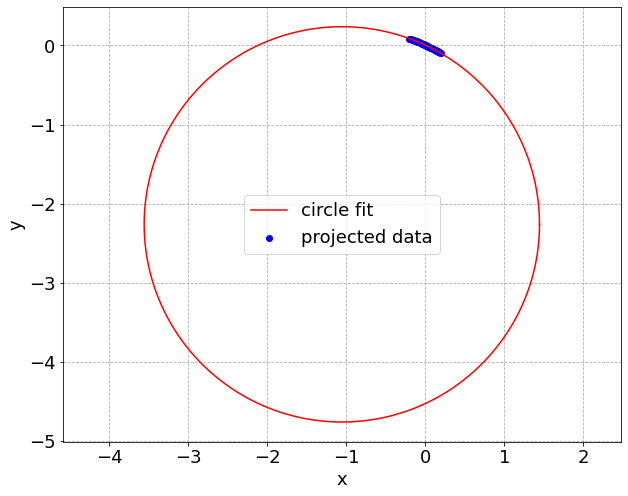

In [673]:
fig, ax = plt.subplots()

t_ = np.linspace(0, 2*np.pi, 361)
x_ = result_params['R']*np.cos(t_) + result_params['Xc']
y_ = result_params['R']*np.sin(t_) + result_params['Yc']

ax.scatter(vecs_rot[:, 0], vecs_rot[:, 1], color='blue', label='projected data')
ax.plot(x_, y_, 'r-', label='circle fit')

ax.axis('equal')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend();

In [ ]:
result_params['Xc'], result_params['Yc']

In [724]:
# rotate back to 3D coordinates
# theta_ = np.arccos(norm_v[2])
k_vec = np.cross(np.array([0, 0, 1]), norm_v)
# k_vec = -np.cross(np.array([0, 0, 1]), norm_v)
k_vec = k_vec / np.linalg.norm(k_vec)
#costheta = norm_v[2]
#costheta = np.dot(norm_v, k_vec)
costheta = np.dot([0, 0, 1], norm_v)
sintheta = (1-costheta**2)**(1/2)
# then project onto fit plane (X, Y)
# using Rodrigues' rotation formula
cen_vec = np.array([result_params['Xc'], result_params['Yc'], 0.])
cen_rot = cen_vec * costheta + np.cross(k_vec, cen_vec) * sintheta + np.outer(np.dot(cen_vec, k_vec), k_vec) * (1 - costheta)
# revert the centroid translation
cen_rot += centroid
# get arbitrary "u" vector
u_fit = vecs_gen[0] - cen_rot
# or get "u" based on parametric definition
th_ = np.arccos(norm_v[2])
#ph_ = np.arccos(norm_v[0] / np.sin(th_))
ph_ = np.arctan2(norm_v[1], norm_v[0])
u_fit_param = np.array([-np.sin(ph_), np.cos(ph_), 0.])

In [729]:
th_

0.7853981633974496

In [730]:
ph_

-0.5235987755983258

In [731]:
phi

-0.5235987755982988

In [732]:
# results to aggregate:

In [733]:
cen_rot

array([[3., 3., 4.]])

In [734]:
result_params['R']

2.5000000000000138

In [735]:
norm_v

array([ 0.61237244, -0.35355339,  0.70710678])

In [736]:
u_fit

array([[1.25000000e+00, 2.16506351e+00, 3.68594044e-14]])

In [737]:
u_fit_param

array([0.5      , 0.8660254, 0.       ])

In [738]:
params

{'r': 2.5,
 'n': array([ 0.61237244, -0.35355339,  0.70710678]),
 'u': array([0.5      , 0.8660254, 0.       ]),
 'C': array([3., 3., 4.])}

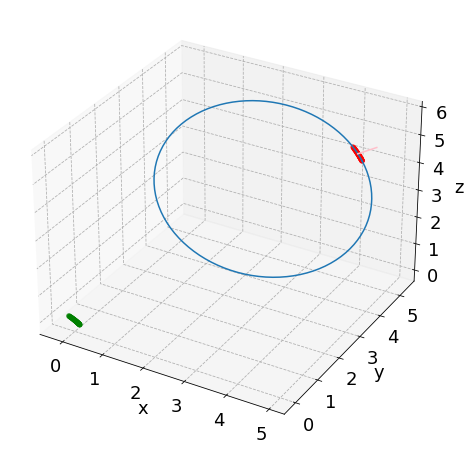

In [743]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(*vecs.T)
ax.scatter3D(*vecs_gen.T, color='red')
ax.plot([centroid[0], centroid[0]+norm_v[0]], [centroid[1], centroid[1]+norm_v[1]], [centroid[2], centroid[2]+norm_v[2]], color='pink')
ax.scatter3D(*vecs_rot.T, color='green')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

### Imported

In [1]:
from survey_axis_analysis import *

In [9]:
#phi = np.pi/4.
# phi = -np.pi/2
# theta = np.pi/3.

# params = {
#     'r': 1.5,
#     'n': np.array([np.cos(phi) * np.sin(theta), np.sin(phi) * np.sin(theta), np.cos(theta)]),
#     'u': np.array([-np.sin(phi), np.cos(phi), 0.]),
#     'C': np.array([0., 0.5, 1.0])
# }

phi = -30/180*np.pi
theta = 45/180*np.pi

params = {
    'r': 2.5,
    'n': np.array([np.cos(phi) * np.sin(theta), np.sin(phi) * np.sin(theta), np.cos(theta)]),
    'u': np.array([-np.sin(phi), np.cos(phi), 0.]),
    'C': np.array([3., 3., 4.]),
    'theta': theta,
    'phi': phi,
}

# df_cir = gen_circle(params, N_points=30, theta_range=[0, np.pi/8], do_noise=False)
# df_cir = gen_circle(params, N_points=30, theta_range=[0, np.pi/8], do_noise=True, stddev_noise=0.005)
df_cir = gen_circle(params, N_points=50, theta_range=[0, np.pi/2], do_noise=True, stddev_noise=0.001)

In [12]:
myCircleFitter = CircleFitter3D()
myCircleFitter.run_fit(df_cir, flip_condition_index=2, flip_condition='<0')

{'r': 2.5012883737461937,
 'n': array([ 0.61245597, -0.35373952,  0.70694132]),
 'u': array([0.50014622, 0.86594096, 0.        ]),
 'C': array([[2.99945487, 2.99860196, 3.99912287]]),
 'theta': 0.7856321327593679,
 'phi': -0.523767629875126}

In [13]:
params

{'r': 2.5,
 'n': array([ 0.61237244, -0.35355339,  0.70710678]),
 'u': array([0.5      , 0.8660254, 0.       ]),
 'C': array([3., 3., 4.]),
 'theta': 0.7853981633974483,
 'phi': -0.5235987755982988}

In [14]:
np.degrees(np.pi/8)

22.5